This notebook implements model training, evaluation and hyperparameter tuning for DistilBERT on the *cleaned + deduplicated* dataset, drawing from Pota et al. (2021) for preprocessing techniques and Singh & Kumar (2023) for insights on model performance in noisy Twitter data. All components below follow the same implementation as in the notebook: *DistilBERT (Original Dataset)*, which incorporates model architectural insights from Ingle et al. (2022).

**Addressing Limitations:**

Pota et al. (2021) focused on the benefits of preprocessing for sentiment analysis but did not explore how these strategies interact with training dynamics in transformer models. Singh & Kumar (2023) demonstrated strong performance of DistilBERT on Twitter sentiment classification but did not examine the role of duplicate tweets in influencing performance. Ingle et al. (2022) proposed partial fine-tuning for RoBERTa to improve training stability, but did not extend this to DistilBERT.

This notebook addresses these gaps by combining semantic preprocessing and duplicate removal with a partially frozen DistilBERT model. Together, these design choices aim to improve training stability and performance on informal tweet data while evaluating how redundancy affects model outcomes.

**References:**

Ingle, D., Tripathi, R., Kumar, A., Patel, K., & Vepa, J. (2022). Investigating the characteristics of a transformer in a few-shot setup: Does freezing layers in RoBERTa help? *Proceedings of the Fifth BlackboxNLP Workshop on Analyzing and Interpreting Neural Networks for NLP*, 238–248. https://doi.org/10.18653/v1/2022.blackboxnlp-1.19

Pota, M., Ventura, M., Fujita, H., & Esposito, M. (2021). Multilingual evaluation of pre-processing for BERT-based sentiment analysis of tweets. *Expert Systems with Applications, 181*, 115119. https://doi.org/10.1016/j.eswa.2021.115119

Singh, A., & Kumar, S. (2023). A comparison of machine learning algorithms and transformer-based methods for Multiclass sentiment analysis on Twitter. *2023 14th International Conference on Computing Communication and Networking Technologies (ICCCNT)*, 1-9. https://doi.org/10.1109/icccnt56998.2023.10306507

---
# **Install & Import Required Libraries**

In [ ]:
# Install required Python libraries for model training and data handling
!pip install torch transformers datasets optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import optuna.visualization as vis
import optuna
import shutil
import os
import json

from google.colab import drive
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments,  AutoModel, AutoConfig, set_seed
from datasets import Dataset
from transformers import EarlyStoppingCallback

set_seed(42)

---
# **1. Data Splitting**

## Load Dataset

In [ ]:
# Load dataset
drive.mount("/content/drive")
data_path = "/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/bert_cleaned_removed_dups_dataset.csv"
df = pd.read_csv(data_path)

# Check dataset information
print(df.info(), "\n")
print(df.head(), "\n")
print(df["label"].value_counts())  # Check class distribution

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99095 entries, 0 to 99094
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          99095 non-null  int64 
 1   cleaned_tweet  99095 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.5+ MB
None 

   label                                      cleaned_tweet
0      0  [USER] [URL] - Awww, that's a bummer.  You sho...
1      0  is upset that he can't update his Facebook by ...
2      0  [USER] I dived many times for the ball. Manage...
3      0    my whole body feels itchy and like its on fire 
4      0  [USER] no, it's not behaving at all. i'm mad. ... 

label
1    49683
0    49412
Name: count, dtype: int64


## Train-Test Split (80%-20%)

In [ ]:
# 80%-20% Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(
    df["cleaned_tweet"],  # Use cleaned tweet text
    df["label"],          # Corresponding sentiment labels
    test_size=0.2,        # 20% test set reserved for final evaluation
    random_state=42,      # Ensures reproducibility
    stratify=df["label"]  # Maintains the same proportion of labels in train & test
)

---
# **2. Feature Engineering**

## Load Tokenizer

In [ ]:
# Load Tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

## Helper Functions:

### Tokenize the dataset

In [ ]:
def tokenize_function(examples):
    return tokenizer(
        examples["text"],        # The column that will be tokenized
        truncation=True,         # Cuts off sequences longer than max_length
        padding="max_length",    # Pads shorter sequences to max_length
        max_length=128           # Max token length
    )

### Convert data to Hugging Face dataset format & apply tokenization

In [ ]:
def prepare_dataset(texts, labels):
    '''
    Converts raw texts and labels into a pandas.DataFrame.
    Converts the DataFrame into a Hugging Face Dataset.
    Applies the tokenize_function (defined earlier) to tokenize all entries.
        - When passing data to a Trainer, Hugging Face expects only the necessary inputs:
        - 'input_ids', 'attention_mask', and optionally 'label'
        - Remove "text" & "__index_level_0__" columns that the model won't use
        - The Trainer (and the model) by default expects a column named "labels".
    '''
    df = pd.DataFrame({"text": texts, "label": labels})
    dataset = Dataset.from_pandas(df)
    dataset = dataset.map(tokenize_function, batched=True).remove_columns(set(dataset.column_names) - {"input_ids", "attention_mask", "label"})
    dataset = dataset.rename_column("label", "labels")
    return dataset

---
# **3.1 Initial Model Training**

## Define Training Arguments

In [ ]:
# Training Arguments for GPU
def create_training_args(model_loader):
    return TrainingArguments(
        output_dir=f"./results_{model_loader.__name__}", # Directory to store checkpoints
        report_to="none",                                # Disable WandB logging
        eval_strategy="epoch",                           # Evaluate after each epoch
        save_strategy="epoch",                           # Save checkpoints each epoch
        per_device_train_batch_size=8,                   # Referenced from Pota et al. (2021)
        per_device_eval_batch_size=8,                    # Same as train batch size for consistency
        num_train_epochs=5,                              # Referenced from Pota et al. (2021)
        learning_rate=3e-5,                              # Referenced from Pota et al. (2021)
        weight_decay=0.01,                               # Prevents overfitting by penalizing large weights
        fp16=True,                                       # Enable mixed precision for faster training on GPU
        gradient_accumulation_steps=16,                  # Accumulate gradients to simulate larger batch size (Pota et al., 2021)
        logging_dir=f"./logs_{model_loader.__name__}",   # Directory for logging training metrics
        logging_strategy="epoch",                        # Log training loss once per epoch
        load_best_model_at_end=True,                     # Important for early stopping
        metric_for_best_model="eval_f1",                 # Use F1-score to determine the best model
        greater_is_better=True,                          # Higher F1 is better (for early stopping and best model logic)
        seed=42                                          # Ensures reproducibility
    )

## Custom Model Architecture

In [ ]:
class CustomDistilBERTClassifier(nn.Module):
    def __init__(self, model_name="distilbert-base-cased", num_labels=2,
                 hidden_units=[256, 64], dropout_rate=0.3, activation=nn.ReLU):
        super().__init__()

        # Load DistilBERT (without classification head)
        self.bert = AutoModel.from_pretrained(model_name)

        # Freeze all layers first
        for param in self.bert.parameters():
            param.requires_grad = False

        # Unfreeze last 2 transformer layers (DistilBERT has 6 layers)
        for layer in self.bert.transformer.layer[-2:]:
            for param in layer.parameters():
                param.requires_grad = True

        # Build custom classification head dynamically
        layers = []
        input_size = self.bert.config.hidden_size  # Typically 768

        for hidden_size in hidden_units:
            layers.append(nn.Dropout(dropout_rate))
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(activation())
            input_size = hidden_size

        layers.append(nn.Linear(input_size, num_labels))
        self.classifier = nn.Sequential(*layers)

    def forward(self, input_ids, attention_mask, labels=None):
        # Get [CLS] token embedding
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]

        logits = self.classifier(cls_output)

        # Hugging Face Trainer expects a dict with loss + logits
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {"loss": loss, "logits": logits}

        return {"logits": logits}

## Helper Functions for Fold-running:

### Load model

In [ ]:
def load_pretrained_model():
    return AutoModelForSequenceClassification.from_pretrained("distilbert-base-cased", num_labels=2)

In [ ]:
def load_custom_model(hidden_units=None, dropout_rate=None, activation=None):
    return CustomDistilBERTClassifier(
        "distilbert-base-cased",
        num_labels=2,
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        activation=activation
    )

### Extract loss histories from the training logs


In [ ]:
def extract_loss_history(log_history):
    # Extract training and evaluation loss histories from log_history
    train_loss_history = [log["loss"] for log in log_history if "loss" in log]
    val_loss_history = [log["eval_loss"] for log in log_history if "eval_loss" in log]
    return train_loss_history, val_loss_history

### Extract evaluation logs from log history and compute the average for each evaluation metric across epochs

In [ ]:
def get_average_epoch_metrics(log_history):
    # Filter logs that include evaluation metrics
    eval_entries = [entry for entry in log_history if "eval_loss" in entry]
    if not eval_entries:
        return {}

    # Get all keys that start with 'eval_'
    metric_keys = [key for key in eval_entries[0].keys() if key.startswith("eval_")]

    avg_metrics = {}
    for key in metric_keys:
        # Compute the average of this metric across all evaluation entries (typically 3 epochs)
        avg_metrics[key] = np.mean([entry[key] for entry in eval_entries])

    return avg_metrics

### Print summary of a fold's results

In [ ]:
def print_fold_summary(fold, avg_epoch_metrics,
                       train_loss_history, val_loss_history,
                       avg_train_loss, avg_eval_loss):

    # Print a formatted summary for a training fold

    print(f"\nFold {fold + 1} Summary")
    print("-" * 50)
    print("\nAverage Metrics Across Epochs:")
    for k, v in avg_epoch_metrics.items():
        print(f"{k:<25}: {v:.4f}")

    print("\nLoss History:")
    print(f"- Training Loss per Epoch   : {[f'{l:.4f}' for l in train_loss_history]}")
    print(f"- Validation Loss per Epoch : {[f'{l:.4f}' for l in val_loss_history]}")
    print(f"- Average Training Loss     : {avg_train_loss:.4f}")
    print(f"- Average Validation Loss   : {avg_eval_loss:.4f}")
    print("=" * 60)

### Define evaluation metrics: accuracy, precision, recall & F1 score

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

## Main Function to Run a Single Fold

In [ ]:
def run_fold(fold, train_texts, train_labels, val_texts, val_labels, training_args, model_loader):
    # Prepare tokenized datasets for training and validation
    train_dataset = prepare_dataset(train_texts, train_labels)
    val_dataset = prepare_dataset(val_texts, val_labels)

    # Load the model and move it to GPU
    model = model_loader()
    model.to(device)

    # Initialize the Trainer with compute_metrics and an early stopping callback
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )

    trainer.train() # Train the model on the current fold
    log_history = trainer.state.log_history # Retrieve training log history
    train_loss_history, val_loss_history = extract_loss_history(log_history) # Extract loss histories
    avg_epoch_metrics = get_average_epoch_metrics(log_history) # Compute average evaluation metrics

    # Compute average losses across epochs
    avg_train_loss = np.mean(train_loss_history) if train_loss_history else None
    avg_eval_loss = np.mean(val_loss_history) if val_loss_history else None

    # Print a summary of results for this fold
    print_fold_summary(fold, avg_epoch_metrics, train_loss_history, val_loss_history, avg_train_loss, avg_eval_loss)

    return {
        "avg_epoch_metrics": avg_epoch_metrics, # average evaluation metrics across all epochs
        "train_loss_history": train_loss_history, # training loss history
        "val_loss_history": val_loss_history, # validation loss history
        "avg_train_loss": avg_train_loss, # average training loss across all epochs
        "avg_eval_loss": avg_eval_loss, # average validation loss across all epochs
        "log_history": trainer.state.log_history
    }

## Check GPU Availability

In [ ]:
# Set up GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")  # Should print "cuda" if GPU is available

Using device: cuda


## Perform 5-Fold Cross-Validation on the Training Set

In [ ]:
def run_cross_validation(x_train, y_train, training_args, model_loader, k = 5):
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train, y_train)):
        print(f"\nRunning Fold {fold + 1}/{k}")

        # Split training data into 80% train, 20% validation for this fold
        fold_x_train, fold_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
        fold_y_train, fold_y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train and evaluate the fold
        result = run_fold(fold, fold_x_train, fold_y_train, fold_x_val, fold_y_val, training_args, model_loader)
        fold_results.append(result)

    return fold_results

**WARNING**: Running the below code chunk will take approximately 1 hour on GPU

In [ ]:
model_loader = load_pretrained_model
training_args = create_training_args(model_loader)
fold_results_pretrained_model = run_cross_validation(x_train, y_train, training_args, model_loader)


Running Fold 1/5


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.438600,0.392092,0.821771,0.823097,0.821771,0.821608
2,0.338900,0.389354,0.829591,0.831183,0.829591,0.829407
3,0.263900,0.417725,0.829276,0.829276,0.829276,0.829276
4,0.200200,0.483086,0.825744,0.826183,0.825744,0.825697



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4206
eval_accuracy            : 0.8266
eval_precision           : 0.8274
eval_recall              : 0.8266
eval_f1                  : 0.8265
eval_runtime             : 17.1996
eval_samples_per_second  : 921.8942
eval_steps_per_second    : 115.2367

Loss History:
- Training Loss per Epoch   : ['0.4386', '0.3389', '0.2639', '0.2002']
- Validation Loss per Epoch : ['0.3921', '0.3894', '0.4177', '0.4831']
- Average Training Loss     : 0.3104
- Average Validation Loss   : 0.4206

Running Fold 2/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.440800,0.387057,0.827310,0.827334,0.827310,0.827304
2,0.339500,0.389005,0.832040,0.832061,0.832040,0.832040
3,0.262800,0.422084,0.829328,0.829799,0.829328,0.829278
4,0.198400,0.482567,0.827562,0.827908,0.827562,0.827526



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4202
eval_accuracy            : 0.8291
eval_precision           : 0.8293
eval_recall              : 0.8291
eval_f1                  : 0.8290
eval_runtime             : 17.2291
eval_samples_per_second  : 920.2510
eval_steps_per_second    : 115.0385

Loss History:
- Training Loss per Epoch   : ['0.4408', '0.3395', '0.2628', '0.1984']
- Validation Loss per Epoch : ['0.3871', '0.3890', '0.4221', '0.4826']
- Average Training Loss     : 0.3104
- Average Validation Loss   : 0.4202

Running Fold 3/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.438000,0.392150,0.822832,0.822971,0.822832,0.822819
2,0.339300,0.393146,0.826742,0.827513,0.826742,0.826655
3,0.264100,0.415653,0.829139,0.829210,0.829139,0.829134
4,0.157000,0.521017,0.828761,0.828842,0.828761,0.828754



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4376
eval_accuracy            : 0.8269
eval_precision           : 0.8273
eval_recall              : 0.8269
eval_f1                  : 0.8268
eval_runtime             : 17.3187
eval_samples_per_second  : 915.5116
eval_steps_per_second    : 114.4460

Loss History:
- Training Loss per Epoch   : ['0.4380', '0.3393', '0.2641', '0.1993', '0.1570']
- Validation Loss per Epoch : ['0.3922', '0.3931', '0.4157', '0.4663', '0.5210']
- Average Training Loss     : 0.2795
- Average Validation Loss   : 0.4376

Running Fold 4/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.440500,0.392499,0.823021,0.823092,0.823021,0.823016
2,0.338300,0.396104,0.827562,0.829179,0.827562,0.827371
3,0.259600,0.424775,0.826364,0.826872,0.826364,0.826308
4,0.195300,0.484220,0.823652,0.823934,0.823652,0.823622



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4244
eval_accuracy            : 0.8251
eval_precision           : 0.8258
eval_recall              : 0.8251
eval_f1                  : 0.8251
eval_runtime             : 17.3091
eval_samples_per_second  : 916.0105
eval_steps_per_second    : 114.5085

Loss History:
- Training Loss per Epoch   : ['0.4405', '0.3383', '0.2596', '0.1953']
- Validation Loss per Epoch : ['0.3925', '0.3961', '0.4248', '0.4842']
- Average Training Loss     : 0.3084
- Average Validation Loss   : 0.4244

Running Fold 5/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.434800,0.398798,0.822832,0.822986,0.822832,0.822804
2,0.335300,0.389711,0.827815,0.828283,0.827815,0.827764
3,0.260200,0.434834,0.826490,0.827216,0.826490,0.826380
4,0.198200,0.476634,0.827058,0.827060,0.827058,0.827056



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4250
eval_accuracy            : 0.8260
eval_precision           : 0.8264
eval_recall              : 0.8260
eval_f1                  : 0.8260
eval_runtime             : 17.3330
eval_samples_per_second  : 914.7347
eval_steps_per_second    : 114.3492

Loss History:
- Training Loss per Epoch   : ['0.4348', '0.3353', '0.2602', '0.1982']
- Validation Loss per Epoch : ['0.3988', '0.3897', '0.4348', '0.4766']
- Average Training Loss     : 0.3071
- Average Validation Loss   : 0.4250


**WARNING**: Running the below code chunk will take approximately 5 hours on GPU

In [ ]:
# Define architecture experiments
experiments = [
    {"name": "baseline", "hidden_units": [256]},
    {"name": "medium", "hidden_units": [256, 64]},
    {"name": "deep", "hidden_units": [512, 256, 64]},
    {"name": "wide", "hidden_units": [512]},
    {"name": "shallow", "hidden_units": [64]},
]

# Dictionary to store results
fold_results_custom_model = {}

# Loop over each architecture
for exp in experiments:
    print(f"\nRunning Experiment: {exp['name']} | Architecture: {exp['hidden_units']}")

    # Wrap load_custom_model to pass parameters
    model_loader = lambda: load_custom_model(
        hidden_units=exp["hidden_units"],
        dropout_rate=0.3,             # You can also vary this if needed
        activation=nn.ReLU            # Try nn.GELU or nn.Tanh for other runs
    )

    # Create training arguments
    training_args = create_training_args(model_loader)

    # Run 5-fold cross-validation
    fold_results = run_cross_validation(x_train, y_train, training_args, model_loader)

    # Save results under experiment name
    fold_results_custom_model[exp["name"]] = fold_results


Running Experiment: baseline | Architecture: [256]

Running Fold 1/5


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.488900,0.436763,0.798562,0.798683,0.798562,0.798549
2,0.429900,0.426211,0.803734,0.807741,0.803734,0.803133
3,0.405400,0.413850,0.812878,0.812881,0.812878,0.812879
4,0.374300,0.415160,0.816978,0.817392,0.816978,0.816930



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4218
eval_accuracy            : 0.8096
eval_precision           : 0.8105
eval_recall              : 0.8096
eval_f1                  : 0.8094
eval_runtime             : 17.3301
eval_samples_per_second  : 914.9626
eval_steps_per_second    : 114.3706

Loss History:
- Training Loss per Epoch   : ['0.4889', '0.4299', '0.4054', '0.3862', '0.3743']
- Validation Loss per Epoch : ['0.4368', '0.4262', '0.4138', '0.4169', '0.4152']
- Average Training Loss     : 0.4169
- Average Validation Loss   : 0.4218

Running Fold 2/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.491100,0.433307,0.799243,0.800237,0.799243,0.799097
2,0.430000,0.420225,0.810407,0.810408,0.810407,0.810406
3,0.404300,0.415508,0.814443,0.815288,0.814443,0.814336
4,0.371900,0.414293,0.816399,0.816550,0.816399,0.816383



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4191
eval_accuracy            : 0.8112
eval_precision           : 0.8116
eval_recall              : 0.8112
eval_f1                  : 0.8111
eval_runtime             : 17.2286
eval_samples_per_second  : 920.2908
eval_steps_per_second    : 115.0436

Loss History:
- Training Loss per Epoch   : ['0.4911', '0.4300', '0.4043', '0.3839', '0.3719']
- Validation Loss per Epoch : ['0.4333', '0.4202', '0.4155', '0.4120', '0.4143']
- Average Training Loss     : 0.4162
- Average Validation Loss   : 0.4191

Running Fold 3/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.489100,0.434018,0.802586,0.802727,0.802586,0.802570
2,0.430200,0.421817,0.805046,0.805158,0.805046,0.805021
3,0.404800,0.416877,0.809398,0.810491,0.809398,0.809249
4,0.372800,0.415962,0.815642,0.815853,0.815642,0.815619



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4206
eval_accuracy            : 0.8090
eval_precision           : 0.8095
eval_recall              : 0.8090
eval_f1                  : 0.8089
eval_runtime             : 17.2476
eval_samples_per_second  : 919.2672
eval_steps_per_second    : 114.9156

Loss History:
- Training Loss per Epoch   : ['0.4891', '0.4302', '0.4048', '0.3873', '0.3728']
- Validation Loss per Epoch : ['0.4340', '0.4218', '0.4169', '0.4145', '0.4160']
- Average Training Loss     : 0.4168
- Average Validation Loss   : 0.4206

Running Fold 4/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.487800,0.445323,0.794765,0.794983,0.794765,0.794737
2,0.428500,0.425317,0.801766,0.802591,0.801766,0.801649
3,0.403800,0.426869,0.804541,0.806216,0.804541,0.804247
4,0.373400,0.421409,0.809587,0.809685,0.809587,0.809577



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4281
eval_accuracy            : 0.8039
eval_precision           : 0.8045
eval_recall              : 0.8039
eval_f1                  : 0.8038
eval_runtime             : 17.2956
eval_samples_per_second  : 916.7504
eval_steps_per_second    : 114.6008

Loss History:
- Training Loss per Epoch   : ['0.4878', '0.4285', '0.4038', '0.3843', '0.3734']
- Validation Loss per Epoch : ['0.4453', '0.4253', '0.4269', '0.4213', '0.4214']
- Average Training Loss     : 0.4156
- Average Validation Loss   : 0.4281

Running Fold 5/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.485800,0.443087,0.793630,0.793810,0.793630,0.793588
2,0.427600,0.423263,0.807695,0.807774,0.807695,0.807688
3,0.402500,0.417889,0.810155,0.810190,0.810155,0.810152
4,0.371400,0.420455,0.812299,0.812305,0.812299,0.812296



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4251
eval_accuracy            : 0.8072
eval_precision           : 0.8073
eval_recall              : 0.8072
eval_f1                  : 0.8072
eval_runtime             : 17.2525
eval_samples_per_second  : 919.0082
eval_steps_per_second    : 114.8834

Loss History:
- Training Loss per Epoch   : ['0.4858', '0.4276', '0.4025', '0.3840', '0.3714']
- Validation Loss per Epoch : ['0.4431', '0.4233', '0.4179', '0.4209', '0.4205']
- Average Training Loss     : 0.4143
- Average Validation Loss   : 0.4251

Running Experiment: medium | Architecture: [256, 64]

Running Fold 1/5


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.499900,0.440371,0.798058,0.798254,0.798058,0.798034
2,0.433500,0.426921,0.804427,0.807701,0.804427,0.803942
3,0.409600,0.416783,0.814707,0.814824,0.814707,0.814696
4,0.379500,0.420208,0.817230,0.817822,0.817230,0.817159



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4249
eval_accuracy            : 0.8099
eval_precision           : 0.8107
eval_recall              : 0.8099
eval_f1                  : 0.8098
eval_runtime             : 17.4415
eval_samples_per_second  : 909.1014
eval_steps_per_second    : 113.6376

Loss History:
- Training Loss per Epoch   : ['0.4999', '0.4335', '0.4096', '0.3906', '0.3795']
- Validation Loss per Epoch : ['0.4404', '0.4269', '0.4168', '0.4201', '0.4202']
- Average Training Loss     : 0.4226
- Average Validation Loss   : 0.4249

Running Fold 2/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.503000,0.436554,0.801009,0.801429,0.801009,0.800953
2,0.435400,0.422501,0.810091,0.810099,0.810091,0.810088
3,0.412000,0.417568,0.812993,0.814592,0.812993,0.812778
4,0.379100,0.416754,0.814822,0.814926,0.814822,0.814812



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4217
eval_accuracy            : 0.8110
eval_precision           : 0.8114
eval_recall              : 0.8110
eval_f1                  : 0.8109
eval_runtime             : 17.4704
eval_samples_per_second  : 907.5382
eval_steps_per_second    : 113.4496

Loss History:
- Training Loss per Epoch   : ['0.5030', '0.4354', '0.4120', '0.3905', '0.3791']
- Validation Loss per Epoch : ['0.4366', '0.4225', '0.4176', '0.4149', '0.4168']
- Average Training Loss     : 0.4240
- Average Validation Loss   : 0.4217

Running Fold 3/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.502300,0.438291,0.797792,0.798095,0.797792,0.797729
2,0.434000,0.426980,0.804415,0.805094,0.804415,0.804289
3,0.409400,0.422993,0.808325,0.811350,0.808325,0.807892
4,0.378700,0.420411,0.813371,0.813824,0.813371,0.813316



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4254
eval_accuracy            : 0.8070
eval_precision           : 0.8081
eval_recall              : 0.8070
eval_f1                  : 0.8068
eval_runtime             : 17.4824
eval_samples_per_second  : 906.9368
eval_steps_per_second    : 113.3744

Loss History:
- Training Loss per Epoch   : ['0.5023', '0.4340', '0.4094', '0.3901', '0.3787']
- Validation Loss per Epoch : ['0.4383', '0.4270', '0.4230', '0.4184', '0.4204']
- Average Training Loss     : 0.4229
- Average Validation Loss   : 0.4254

Running Fold 4/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.498000,0.447548,0.794071,0.794916,0.794071,0.793943
2,0.433800,0.427113,0.802460,0.803653,0.802460,0.802288
3,0.408300,0.424291,0.805424,0.806318,0.805424,0.805263
4,0.378500,0.422392,0.811227,0.811353,0.811227,0.811214



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4284
eval_accuracy            : 0.8048
eval_precision           : 0.8054
eval_recall              : 0.8048
eval_f1                  : 0.8047
eval_runtime             : 17.4786
eval_samples_per_second  : 907.1092
eval_steps_per_second    : 113.3958

Loss History:
- Training Loss per Epoch   : ['0.4980', '0.4338', '0.4083', '0.3900', '0.3785']
- Validation Loss per Epoch : ['0.4475', '0.4271', '0.4243', '0.4209', '0.4224']
- Average Training Loss     : 0.4217
- Average Validation Loss   : 0.4284

Running Fold 5/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.498700,0.447501,0.793630,0.793878,0.793630,0.793575
2,0.433300,0.429537,0.804541,0.805786,0.804541,0.804364
3,0.406800,0.423083,0.809272,0.809611,0.809272,0.809230
4,0.376400,0.422110,0.812299,0.812368,0.812299,0.812293



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4283
eval_accuracy            : 0.8067
eval_precision           : 0.8071
eval_recall              : 0.8067
eval_f1                  : 0.8066
eval_runtime             : 17.5171
eval_samples_per_second  : 905.1230
eval_steps_per_second    : 113.1476

Loss History:
- Training Loss per Epoch   : ['0.4987', '0.4333', '0.4068', '0.3897', '0.3764']
- Validation Loss per Epoch : ['0.4475', '0.4295', '0.4231', '0.4191', '0.4221']
- Average Training Loss     : 0.4210
- Average Validation Loss   : 0.4283

Running Experiment: deep | Architecture: [512, 256, 64]

Running Fold 1/5


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.509300,0.443683,0.796922,0.796929,0.796922,0.796923
2,0.435900,0.427253,0.804049,0.807466,0.804049,0.803540
3,0.412100,0.417667,0.813951,0.814180,0.813951,0.813925
4,0.382500,0.419501,0.815653,0.816590,0.815653,0.815535



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4257
eval_accuracy            : 0.8090
eval_precision           : 0.8099
eval_recall              : 0.8090
eval_f1                  : 0.8088
eval_runtime             : 17.6391
eval_samples_per_second  : 898.9184
eval_steps_per_second    : 112.3648

Loss History:
- Training Loss per Epoch   : ['0.5093', '0.4359', '0.4121', '0.3934', '0.3825']
- Validation Loss per Epoch : ['0.4437', '0.4273', '0.4177', '0.4203', '0.4195']
- Average Training Loss     : 0.4266
- Average Validation Loss   : 0.4257

Running Fold 2/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.513200,0.439153,0.799054,0.799852,0.799054,0.798939
2,0.436800,0.425265,0.809524,0.809524,0.809524,0.809523
3,0.411700,0.418127,0.815768,0.816425,0.815768,0.815687
4,0.379700,0.415945,0.816083,0.816161,0.816083,0.816077



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4225
eval_accuracy            : 0.8112
eval_precision           : 0.8115
eval_recall              : 0.8112
eval_f1                  : 0.8111
eval_runtime             : 17.6522
eval_samples_per_second  : 898.2094
eval_steps_per_second    : 112.2834

Loss History:
- Training Loss per Epoch   : ['0.5132', '0.4368', '0.4117', '0.3932', '0.3797']
- Validation Loss per Epoch : ['0.4392', '0.4253', '0.4181', '0.4141', '0.4159']
- Average Training Loss     : 0.4269
- Average Validation Loss   : 0.4225

Running Fold 3/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.510600,0.439585,0.798360,0.798406,0.798360,0.798357
2,0.436300,0.425018,0.805235,0.805247,0.805235,0.805235
3,0.409800,0.419832,0.808199,0.809753,0.808199,0.807982
4,0.379200,0.418856,0.812614,0.813324,0.812614,0.812524



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4240
eval_accuracy            : 0.8071
eval_precision           : 0.8078
eval_recall              : 0.8071
eval_f1                  : 0.8070
eval_runtime             : 17.6876
eval_samples_per_second  : 896.3996
eval_steps_per_second    : 112.0572

Loss History:
- Training Loss per Epoch   : ['0.5106', '0.4363', '0.4098', '0.3906', '0.3792']
- Validation Loss per Epoch : ['0.4396', '0.4250', '0.4198', '0.4168', '0.4189']
- Average Training Loss     : 0.4253
- Average Validation Loss   : 0.4240

Running Fold 4/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.509000,0.455385,0.792621,0.793396,0.792621,0.792503
2,0.435900,0.428047,0.801640,0.802759,0.801640,0.801478
3,0.410300,0.426562,0.806496,0.807052,0.806496,0.806394
4,0.380700,0.421093,0.807884,0.808140,0.807884,0.807854



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4305
eval_accuracy            : 0.8034
eval_precision           : 0.8039
eval_recall              : 0.8034
eval_f1                  : 0.8033
eval_runtime             : 17.7136
eval_samples_per_second  : 895.0800
eval_steps_per_second    : 111.8920

Loss History:
- Training Loss per Epoch   : ['0.5090', '0.4359', '0.4103', '0.3916', '0.3807']
- Validation Loss per Epoch : ['0.4554', '0.4280', '0.4266', '0.4216', '0.4211']
- Average Training Loss     : 0.4255
- Average Validation Loss   : 0.4305

Running Fold 5/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.508300,0.447765,0.793188,0.793195,0.793188,0.793185
2,0.433700,0.431296,0.804730,0.805535,0.804730,0.804619
3,0.407800,0.424181,0.809208,0.809496,0.809208,0.809174
4,0.380200,0.422376,0.812740,0.812784,0.812740,0.812738



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4296
eval_accuracy            : 0.8062
eval_precision           : 0.8065
eval_recall              : 0.8062
eval_f1                  : 0.8062
eval_runtime             : 17.6780
eval_samples_per_second  : 896.8802
eval_steps_per_second    : 112.1172

Loss History:
- Training Loss per Epoch   : ['0.5083', '0.4337', '0.4078', '0.3922', '0.3802']
- Validation Loss per Epoch : ['0.4478', '0.4313', '0.4242', '0.4224', '0.4224']
- Average Training Loss     : 0.4244
- Average Validation Loss   : 0.4296

Running Experiment: wide | Architecture: [512]

Running Fold 1/5


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.488000,0.435271,0.798877,0.798878,0.798877,0.798877
2,0.429600,0.424470,0.805121,0.807852,0.805121,0.804721
3,0.404400,0.413895,0.813509,0.813534,0.813509,0.813502
4,0.372500,0.415669,0.817672,0.818268,0.817672,0.817600



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4210
eval_accuracy            : 0.8103
eval_precision           : 0.8109
eval_recall              : 0.8103
eval_f1                  : 0.8102
eval_runtime             : 17.2665
eval_samples_per_second  : 918.3298
eval_steps_per_second    : 114.7912

Loss History:
- Training Loss per Epoch   : ['0.4880', '0.4296', '0.4044', '0.3848', '0.3725']
- Validation Loss per Epoch : ['0.4353', '0.4245', '0.4139', '0.4156', '0.4157']
- Average Training Loss     : 0.4159
- Average Validation Loss   : 0.4210

Running Fold 2/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.489500,0.433393,0.799937,0.800885,0.799937,0.799799
2,0.429600,0.419311,0.810470,0.810480,0.810470,0.810466
3,0.403800,0.415796,0.815389,0.816686,0.815389,0.815221
4,0.371300,0.414739,0.817660,0.817845,0.817660,0.817641



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4192
eval_accuracy            : 0.8122
eval_precision           : 0.8127
eval_recall              : 0.8122
eval_f1                  : 0.8121
eval_runtime             : 17.3071
eval_samples_per_second  : 916.1418
eval_steps_per_second    : 114.5252

Loss History:
- Training Loss per Epoch   : ['0.4895', '0.4296', '0.4038', '0.3841', '0.3713']
- Validation Loss per Epoch : ['0.4334', '0.4193', '0.4158', '0.4126', '0.4147']
- Average Training Loss     : 0.4157
- Average Validation Loss   : 0.4192

Running Fold 3/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.488600,0.433481,0.801640,0.801650,0.801640,0.801636
2,0.429900,0.420394,0.806812,0.806813,0.806812,0.806812
3,0.405100,0.417623,0.809650,0.811401,0.809650,0.809407
4,0.372400,0.416500,0.814128,0.814711,0.814128,0.814056



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4207
eval_accuracy            : 0.8085
eval_precision           : 0.8093
eval_recall              : 0.8085
eval_f1                  : 0.8084
eval_runtime             : 17.2696
eval_samples_per_second  : 918.0930
eval_steps_per_second    : 114.7688

Loss History:
- Training Loss per Epoch   : ['0.4886', '0.4299', '0.4051', '0.3866', '0.3724']
- Validation Loss per Epoch : ['0.4335', '0.4204', '0.4176', '0.4155', '0.4165']
- Average Training Loss     : 0.4165
- Average Validation Loss   : 0.4207

Running Fold 4/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.485300,0.442347,0.794324,0.794432,0.794324,0.794311
2,0.427800,0.423942,0.803217,0.804263,0.803217,0.803068
3,0.401900,0.426644,0.806433,0.807961,0.806433,0.806168
4,0.372200,0.420421,0.810091,0.810312,0.810091,0.810066



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4267
eval_accuracy            : 0.8050
eval_precision           : 0.8056
eval_recall              : 0.8050
eval_f1                  : 0.8049
eval_runtime             : 17.2676
eval_samples_per_second  : 918.2116
eval_steps_per_second    : 114.7838

Loss History:
- Training Loss per Epoch   : ['0.4853', '0.4278', '0.4019', '0.3835', '0.3722']
- Validation Loss per Epoch : ['0.4423', '0.4239', '0.4266', '0.4201', '0.4204']
- Average Training Loss     : 0.4141
- Average Validation Loss   : 0.4267

Running Fold 5/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.484600,0.444180,0.794639,0.795462,0.794639,0.794476
2,0.426900,0.422531,0.805550,0.805569,0.805550,0.805550
3,0.401300,0.419587,0.809082,0.809086,0.809082,0.809083
4,0.370500,0.420455,0.810596,0.810600,0.810596,0.810596



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4253
eval_accuracy            : 0.8059
eval_precision           : 0.8062
eval_recall              : 0.8059
eval_f1                  : 0.8059
eval_runtime             : 17.2943
eval_samples_per_second  : 916.8096
eval_steps_per_second    : 114.6084

Loss History:
- Training Loss per Epoch   : ['0.4846', '0.4269', '0.4013', '0.3829', '0.3705']
- Validation Loss per Epoch : ['0.4442', '0.4225', '0.4196', '0.4198', '0.4205']
- Average Training Loss     : 0.4132
- Average Validation Loss   : 0.4253

Running Experiment: shallow | Architecture: [64]

Running Fold 1/5


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.490700,0.436663,0.799634,0.799654,0.799634,0.799634
2,0.431000,0.429777,0.801463,0.806384,0.801463,0.800709
3,0.406400,0.414248,0.811491,0.811538,0.811491,0.811488
4,0.375500,0.416338,0.813698,0.814608,0.813698,0.813581



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4227
eval_accuracy            : 0.8079
eval_precision           : 0.8091
eval_recall              : 0.8079
eval_f1                  : 0.8077
eval_runtime             : 17.2677
eval_samples_per_second  : 918.2612
eval_steps_per_second    : 114.7826

Loss History:
- Training Loss per Epoch   : ['0.4907', '0.4310', '0.4064', '0.3877', '0.3755']
- Validation Loss per Epoch : ['0.4367', '0.4298', '0.4142', '0.4166', '0.4163']
- Average Training Loss     : 0.4183
- Average Validation Loss   : 0.4227

Running Fold 2/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.492700,0.435766,0.797225,0.799115,0.797225,0.796933
2,0.429500,0.420718,0.810470,0.810484,0.810470,0.810470
3,0.405200,0.416997,0.813560,0.815504,0.813560,0.813298
4,0.373800,0.413727,0.816714,0.817050,0.816714,0.816676



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4200
eval_accuracy            : 0.8109
eval_precision           : 0.8118
eval_recall              : 0.8109
eval_f1                  : 0.8107
eval_runtime             : 17.3004
eval_samples_per_second  : 916.4818
eval_steps_per_second    : 114.5674

Loss History:
- Training Loss per Epoch   : ['0.4927', '0.4295', '0.4052', '0.3853', '0.3738']
- Validation Loss per Epoch : ['0.4358', '0.4207', '0.4170', '0.4128', '0.4137']
- Average Training Loss     : 0.4173
- Average Validation Loss   : 0.4200

Running Fold 3/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.492700,0.434564,0.798549,0.798786,0.798549,0.798519
2,0.431200,0.420642,0.806433,0.806446,0.806433,0.806429
3,0.406700,0.419101,0.807947,0.810620,0.807947,0.807564
4,0.374000,0.415917,0.813497,0.814157,0.813497,0.813414



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4211
eval_accuracy            : 0.8071
eval_precision           : 0.8082
eval_recall              : 0.8071
eval_f1                  : 0.8070
eval_runtime             : 17.3239
eval_samples_per_second  : 915.2140
eval_steps_per_second    : 114.4090

Loss History:
- Training Loss per Epoch   : ['0.4927', '0.4312', '0.4067', '0.3880', '0.3740']
- Validation Loss per Epoch : ['0.4346', '0.4206', '0.4191', '0.4152', '0.4159']
- Average Training Loss     : 0.4185
- Average Validation Loss   : 0.4211

Running Fold 4/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.488300,0.445249,0.793882,0.795178,0.793882,0.793680
2,0.428400,0.425416,0.803280,0.805026,0.803280,0.803024
3,0.403100,0.423919,0.808515,0.809465,0.808515,0.808348
4,0.373800,0.418945,0.809082,0.809399,0.809082,0.809044



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4264
eval_accuracy            : 0.8048
eval_precision           : 0.8056
eval_recall              : 0.8048
eval_f1                  : 0.8046
eval_runtime             : 17.2223
eval_samples_per_second  : 920.6092
eval_steps_per_second    : 115.0834

Loss History:
- Training Loss per Epoch   : ['0.4883', '0.4284', '0.4031', '0.3850', '0.3738']
- Validation Loss per Epoch : ['0.4452', '0.4254', '0.4239', '0.4184', '0.4189']
- Average Training Loss     : 0.4157
- Average Validation Loss   : 0.4264

Running Fold 5/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.487500,0.442350,0.793882,0.794122,0.793882,0.793829
2,0.428500,0.422838,0.805424,0.805472,0.805424,0.805421
3,0.403200,0.418262,0.809398,0.809431,0.809398,0.809396
4,0.372700,0.418664,0.811857,0.811917,0.811857,0.811853



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4240
eval_accuracy            : 0.8061
eval_precision           : 0.8062
eval_recall              : 0.8061
eval_f1                  : 0.8061
eval_runtime             : 17.3188
eval_samples_per_second  : 915.5006
eval_steps_per_second    : 114.4450

Loss History:
- Training Loss per Epoch   : ['0.4875', '0.4285', '0.4032', '0.3846', '0.3727']
- Validation Loss per Epoch : ['0.4424', '0.4228', '0.4183', '0.4181', '0.4187']
- Average Training Loss     : 0.4153
- Average Validation Loss   : 0.4240


In [ ]:
for name, results in fold_results_custom_model.items():
    accs = [fold["avg_epoch_metrics"].get("eval_accuracy", np.nan) for fold in results]
    precs = [fold["avg_epoch_metrics"].get("eval_precision", np.nan) for fold in results]
    recalls = [fold["avg_epoch_metrics"].get("eval_recall", np.nan) for fold in results]
    f1s = [fold["avg_epoch_metrics"].get("eval_f1", np.nan) for fold in results]

    avg_acc = np.nanmean(accs)
    avg_prec = np.nanmean(precs)
    avg_recall = np.nanmean(recalls)
    avg_f1 = np.nanmean(f1s)

    print("Average Metrics for Each Experiment:")
    print(f"{name:<10} | Acc: {avg_acc:.4f} | Prec: {avg_prec:.4f} | Recall: {avg_recall:.4f} | F1: {avg_f1:.4f}")

Average Metrics for Each Experiment:
baseline   | Acc: 0.8082 | Prec: 0.8087 | Recall: 0.8082 | F1: 0.8081
Average Metrics for Each Experiment:
medium     | Acc: 0.8079 | Prec: 0.8086 | Recall: 0.8079 | F1: 0.8078
Average Metrics for Each Experiment:
deep       | Acc: 0.8074 | Prec: 0.8079 | Recall: 0.8074 | F1: 0.8073
Average Metrics for Each Experiment:
wide       | Acc: 0.8084 | Prec: 0.8089 | Recall: 0.8084 | F1: 0.8083
Average Metrics for Each Experiment:
shallow    | Acc: 0.8073 | Prec: 0.8082 | Recall: 0.8073 | F1: 0.8072


---
# **3.2 Initial Model Evaluation**

## Helper Functions for Visualization:

### Plot average of evaluation metrics for all epochs per fold

In [ ]:
def plot_avg_epoch_metrics_per_fold(metrics_list):
    folds = np.arange(1, len(metrics_list) + 1)
    avg_accuracies = [m["avg_epoch_metrics"]["eval_accuracy"] for m in metrics_list]
    avg_precisions = [m["avg_epoch_metrics"]["eval_precision"] for m in metrics_list]
    avg_recalls = [m["avg_epoch_metrics"]["eval_recall"] for m in metrics_list]
    avg_f1s = [m["avg_epoch_metrics"]["eval_f1"] for m in metrics_list]

    plt.figure(figsize=(14, 4))

    # Accuracy
    plt.subplot(1, 4, 1)
    plt.bar(folds, [acc * 100 for acc in avg_accuracies], color='skyblue')
    plt.xlabel("Fold")
    plt.title("Average Accuracy (%) per Fold")
    plt.ylim(0, 100)

    # Precision
    plt.subplot(1, 4, 2)
    plt.bar(folds, [prec * 100 for prec in avg_precisions], color='lightgreen')
    plt.xlabel("Fold")
    plt.title("Average Precision (%) per Fold")
    plt.ylim(0, 100)

    # Recall
    plt.subplot(1, 4, 3)
    plt.bar(folds, [rec * 100 for rec in avg_recalls], color='salmon')
    plt.xlabel("Fold")
    plt.title("Average Recall (%) per Fold")
    plt.ylim(0, 100)

    # F1 Score
    plt.subplot(1, 4, 4)
    plt.bar(folds, [f1 * 100 for f1 in avg_f1s], color='plum')
    plt.xlabel("Fold")
    plt.title("Average F1 Score (%) per Fold")
    plt.ylim(0, 100)

    plt.tight_layout()
    plt.show()

    # Print a summary table of average epoch metrics per fold
    print("\nAverage Metrics (%) Across Epochs Per Fold:")
    print("-" * 60)
    print(f"{'Fold':<6}{'Accuracy':<12}{'Precision':<12}{'Recall':<12}{'F1 Score':<12}")
    print("-" * 60)
    for i in range(len(folds)):
        print(f"{folds[i]:<6}{avg_accuracies[i]*100:<12.2f}{avg_precisions[i]*100:<12.2f}{avg_recalls[i]*100:<12.2f}{avg_f1s[i]*100:<12.2f}")


### Plot overall average of evaluation metrics for all epochs for 5-fold

In [ ]:
def plot_avg_epoch_metrics_across_folds(metrics_list):
    avg_accuracy = np.mean([m["avg_epoch_metrics"]["eval_accuracy"] for m in metrics_list])
    avg_precision = np.mean([m["avg_epoch_metrics"]["eval_precision"] for m in metrics_list])
    avg_recall = np.mean([m["avg_epoch_metrics"]["eval_recall"] for m in metrics_list])
    avg_f1 = np.mean([m["avg_epoch_metrics"]["eval_f1"] for m in metrics_list])

    metrics_names = ["Accuracy", "Precision", "Recall", "F1"]
    avg_values = [avg_accuracy * 100, avg_precision * 100, avg_recall * 100, avg_f1 * 100]

    plt.figure(figsize=(6, 4))
    plt.bar(metrics_names, avg_values, color='mediumseagreen')
    plt.ylabel("Average Metric Value (%)")
    plt.title("Overall Average Metrics (%) across 5 Folds")
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

    # Print a summary table of overall avg metrics for all epohcs across folds
    print("\nOverall Average Metrics Across Folds:")
    print("-" * 40)
    print(f"{'Metric':<12}{'Value (%)':>10}")
    print("-" * 40)
    for name, value in zip(metrics_names, avg_values):
        print(f"{name:<12}{value:>10.2f}")

### Plot training and validation loss curves per fold

In [ ]:
def plot_loss_per_fold(metrics_list):
    plt.figure(figsize=(10, 6))

    # To save loss data per fold
    loss_data_all_folds = []

    # Loop over each fold's results
    for i, res in enumerate(metrics_list):
        train_loss = res["train_loss_history"]  # List of training losses (one per epoch)
        val_loss = res["val_loss_history"]      # List of validation losses (one per epoch)

        # Create x-axis values representing epoch numbers
        epochs_train = range(1, len(train_loss) + 1)
        epochs_val = range(1, len(val_loss) + 1)

        # Plot training loss (solid line) and validation loss (dashed line)
        plt.plot(epochs_train, train_loss, marker='o', linestyle='-', label=f"Train Loss - Fold {i+1}")
        plt.plot(epochs_val, val_loss, marker='o', linestyle='--', label=f"Val Loss - Fold {i+1}")

        # Collect loss data for each epoch
        for epoch, t_loss, v_loss in zip(epochs_train, train_loss, val_loss):
            loss_data_all_folds.append({
                "Fold": i + 1,
                "Epoch": epoch,
                "Train Loss": t_loss,
                "Validation Loss": v_loss
            })

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curves per Fold")
    plt.xticks(range(1, max(len(res["train_loss_history"]) for res in metrics_list) + 1)) # Set x-ticks based on the max no of epochs in any fold
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Convert to DataFrame
    df_loss = pd.DataFrame(loss_data_all_folds)

    # Print summary table of loss values
    print("\nLoss Values per Fold and Epoch:")
    print("-" * 50)
    print(f"{'Fold':<6}{'Epoch':<8}{'Train Loss':<15}{'Val Loss':<15}")
    print("-" * 50)
    previous_fold = None
    for _, row in df_loss.iterrows():
        current_fold = int(row['Fold'])
        if previous_fold is not None and current_fold != previous_fold:
            print("-" * 50)  # Separator between folds
        print(f"{current_fold:<6}{int(row['Epoch']):<8}{row['Train Loss']:<15.4f}{row['Validation Loss']:<15.4f}")
        previous_fold = current_fold

    return df_loss

### Plot average of training and validation loss curves for 5-fold

In [ ]:
def plot_avg_loss_across_folds(metrics_list):
    # Extract training and validation loss histories from each fold
    train_loss_histories = [res["train_loss_history"] for res in metrics_list]
    val_loss_histories = [res["val_loss_history"] for res in metrics_list]

    # Find the minimum number of epochs across all folds
    min_epochs = min(min(len(loss) for loss in train_loss_histories),
                     min(len(loss) for loss in val_loss_histories))

    # Trim each fold's loss history to match the minimum number of epochs
    trimmed_train_losses = [loss[:min_epochs] for loss in train_loss_histories]
    trimmed_val_losses = [loss[:min_epochs] for loss in val_loss_histories]

    # Compute average loss at each epoch
    avg_train_loss = np.mean(trimmed_train_losses, axis=0)
    avg_val_loss = np.mean(trimmed_val_losses, axis=0)

    # Plot the average loss curves
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, min_epochs+1), avg_train_loss, color='blue', marker='o', linestyle='-', label="Avg Train Loss")
    plt.plot(range(1, min_epochs+1), avg_val_loss, color='red', marker='s', linestyle='--', label="Avg Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Average Training & Validation Loss Curve Across 5 Folds")
    plt.xticks(range(1, min_epochs + 1))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Create DataFrame
    df_loss = pd.DataFrame({
        "Epoch": list(range(1, min_epochs + 1)),
        "Avg Train Loss": avg_train_loss,
        "Avg Validation Loss": avg_val_loss
    })

    # Print summary table of avg loss values
    print("\nAverage Loss per Epoch Across Folds:")
    print("-" * 45)
    print(f"{'Epoch':<8}{'Train Loss':<16}{'Val Loss':<16}")
    print("-" * 45)
    for epoch in range(min_epochs):
        print(f"{epoch+1:<8}{avg_train_loss[epoch]:<16.4f}{avg_val_loss[epoch]:<16.4f}")

    return df_loss

## Visualize & Evaluate Performance Metrics:

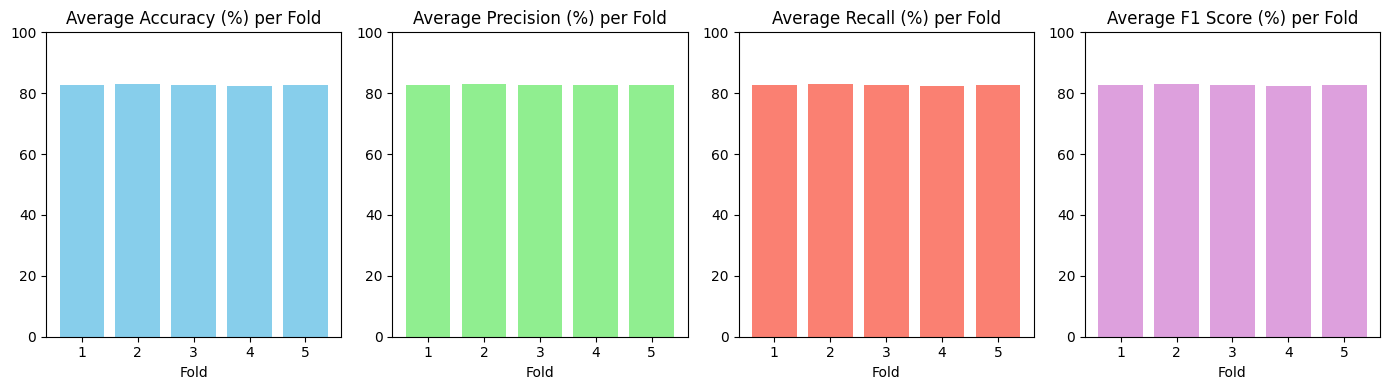


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     82.66       82.74       82.66       82.65       
2     82.91       82.93       82.91       82.90       
3     82.69       82.73       82.69       82.68       
4     82.51       82.58       82.51       82.51       
5     82.60       82.64       82.60       82.60       

Plotting results for experiment: baseline



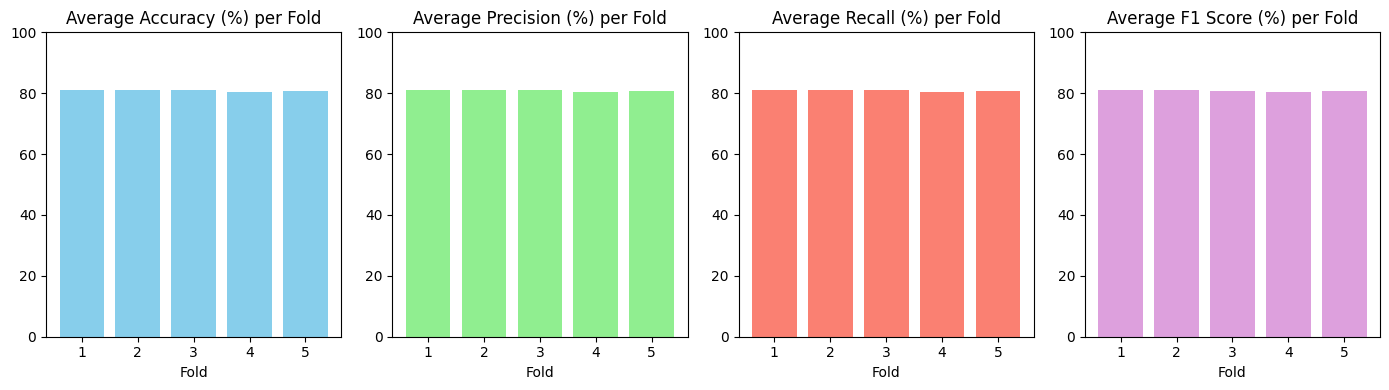


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     80.96       81.05       80.96       80.94       
2     81.12       81.16       81.12       81.11       
3     80.90       80.95       80.90       80.89       
4     80.39       80.45       80.39       80.38       
5     80.72       80.73       80.72       80.72       

Plotting results for experiment: medium



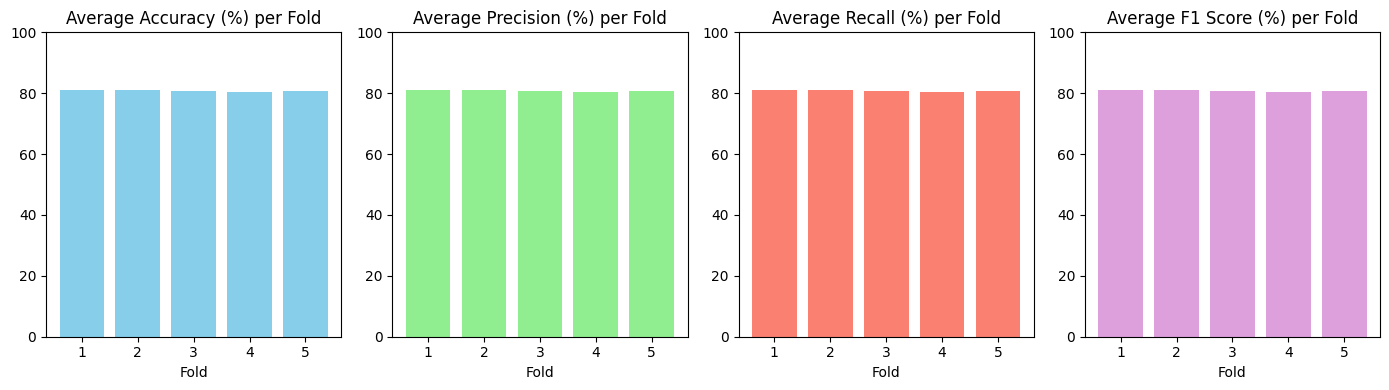


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     80.99       81.07       80.99       80.98       
2     81.10       81.14       81.10       81.09       
3     80.70       80.81       80.70       80.68       
4     80.48       80.54       80.48       80.47       
5     80.67       80.71       80.67       80.66       

Plotting results for experiment: deep



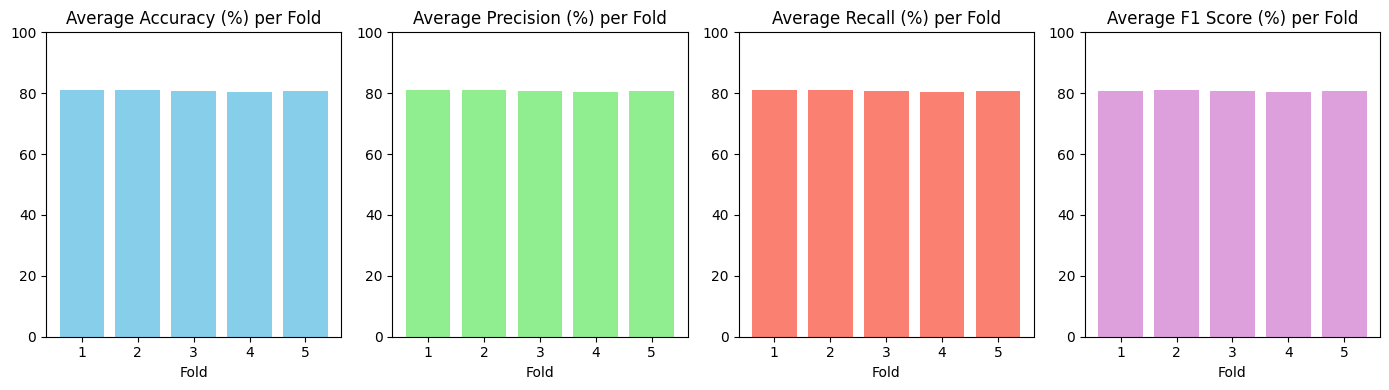


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     80.90       80.99       80.90       80.88       
2     81.12       81.15       81.12       81.11       
3     80.71       80.78       80.71       80.70       
4     80.34       80.39       80.34       80.33       
5     80.62       80.65       80.62       80.62       

Plotting results for experiment: wide



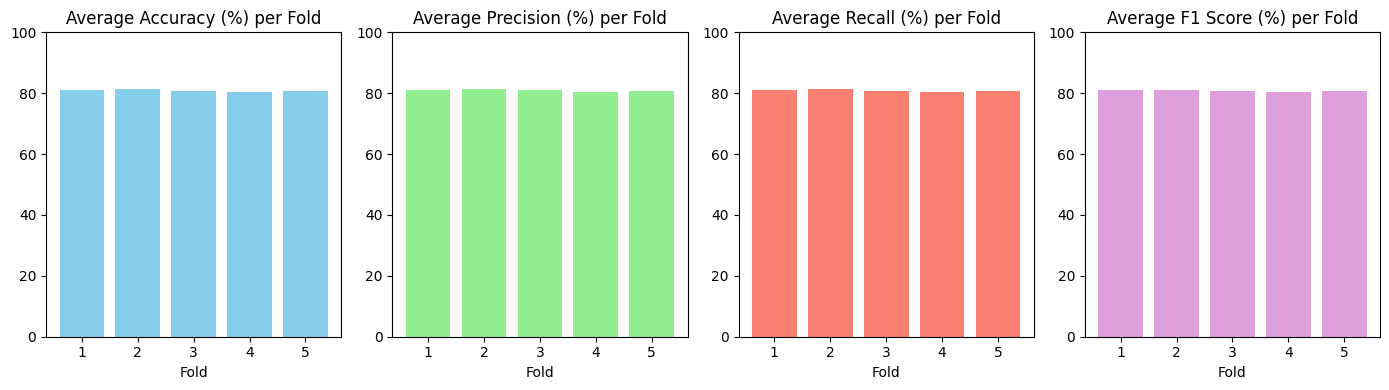


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     81.03       81.09       81.03       81.02       
2     81.22       81.27       81.22       81.21       
3     80.85       80.93       80.85       80.84       
4     80.50       80.56       80.50       80.49       
5     80.59       80.62       80.59       80.59       

Plotting results for experiment: shallow



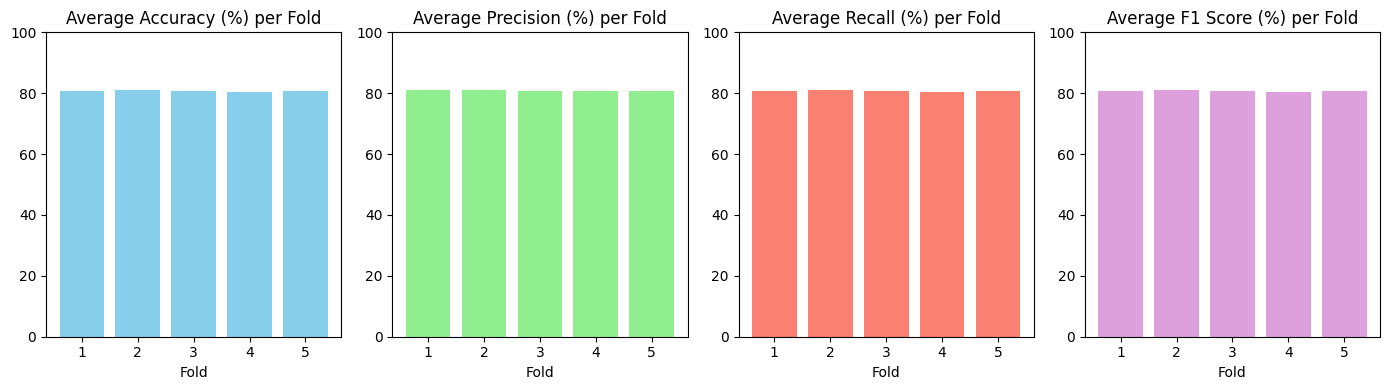


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     80.79       80.91       80.79       80.77       
2     81.09       81.18       81.09       81.07       
3     80.71       80.82       80.71       80.70       
4     80.48       80.56       80.48       80.46       
5     80.61       80.62       80.61       80.61       


In [ ]:
# Plot cross-validation performance metrics (average of epochs) per fold
plot_avg_epoch_metrics_per_fold(fold_results_pretrained_model)

for experiment_name, experiment_results in fold_results_custom_model.items():
    print(f"\nPlotting results for experiment: {experiment_name}\n")
    plot_avg_epoch_metrics_per_fold(experiment_results)

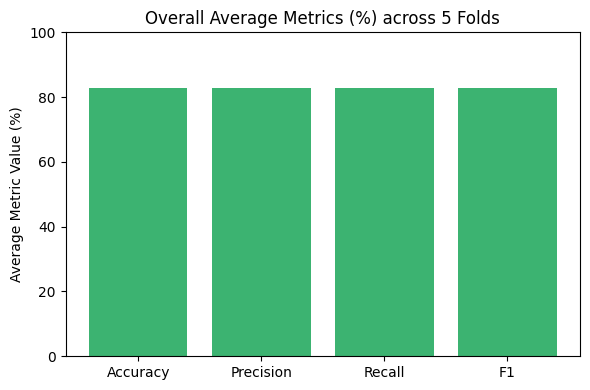


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         82.67
Precision        82.72
Recall           82.67
F1               82.67

Plotting results for experiment: baseline



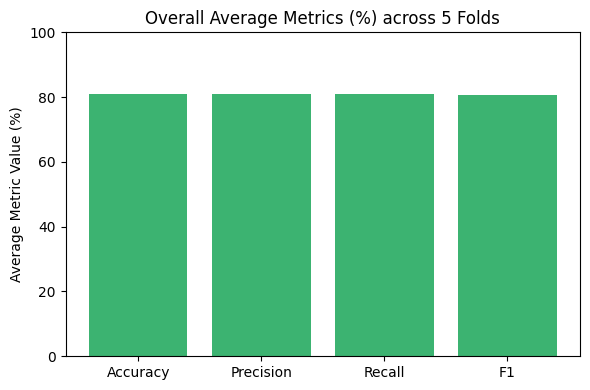


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         80.82
Precision        80.87
Recall           80.82
F1               80.81

Plotting results for experiment: medium



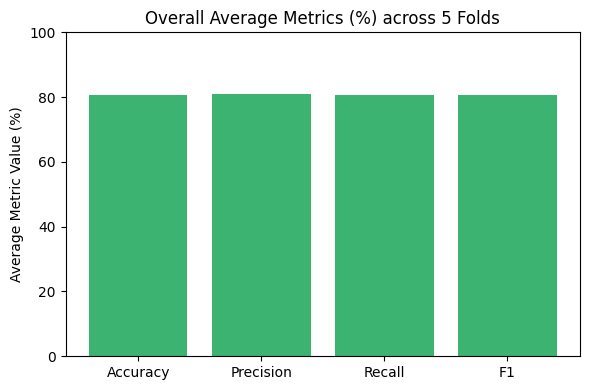


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         80.79
Precision        80.86
Recall           80.79
F1               80.78

Plotting results for experiment: deep



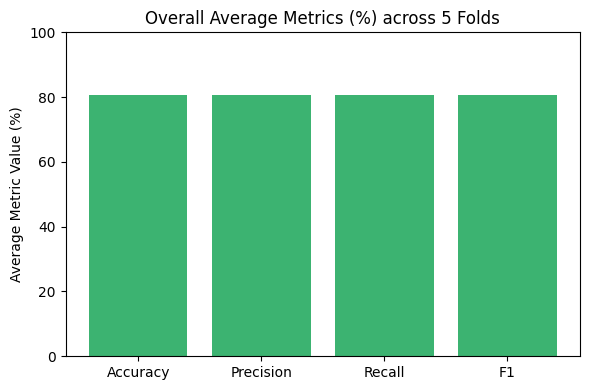


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         80.74
Precision        80.79
Recall           80.74
F1               80.73

Plotting results for experiment: wide



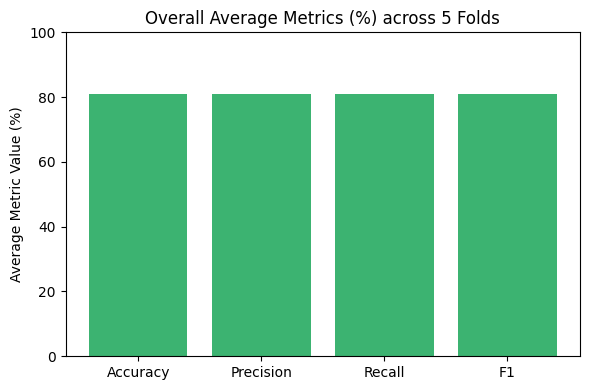


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         80.84
Precision        80.89
Recall           80.84
F1               80.83

Plotting results for experiment: shallow



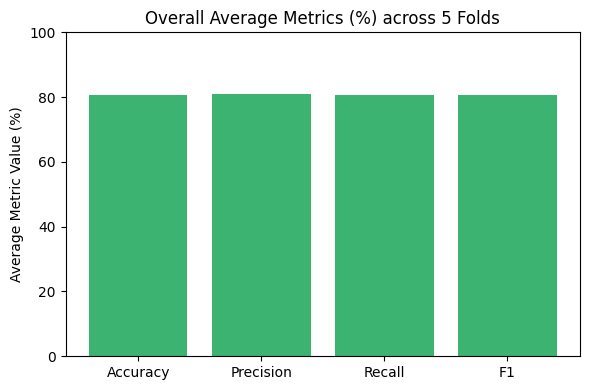


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         80.73
Precision        80.82
Recall           80.73
F1               80.72


In [ ]:
# Plot average performance metrics (average of epochs) for 5-fold
plot_avg_epoch_metrics_across_folds(fold_results_pretrained_model)

for experiment_name, experiment_results in fold_results_custom_model.items():
    print(f"\nPlotting results for experiment: {experiment_name}\n")
    plot_avg_epoch_metrics_across_folds(experiment_results)

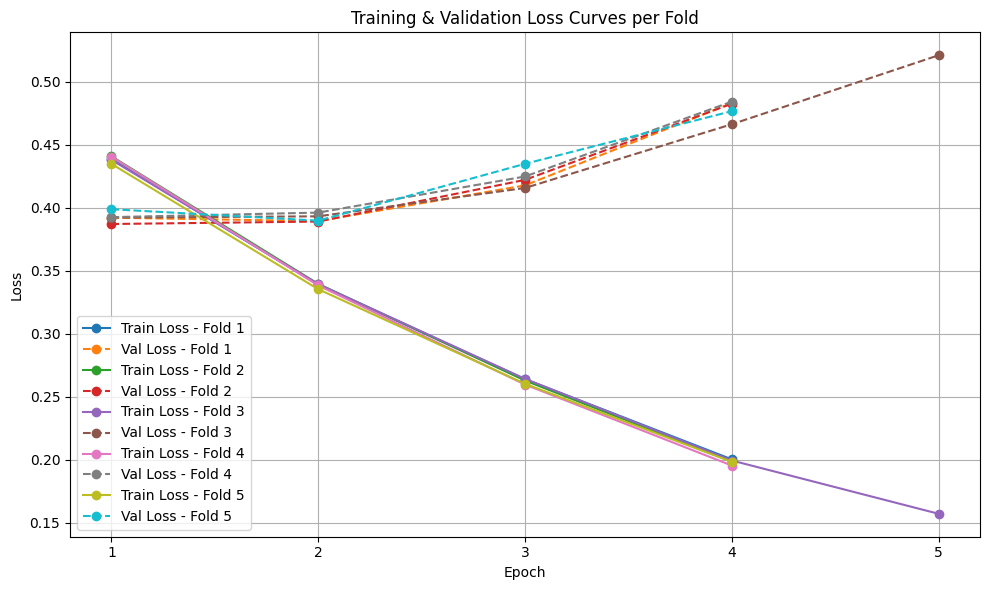


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4386         0.3921         
1     2       0.3389         0.3894         
1     3       0.2639         0.4177         
1     4       0.2002         0.4831         
--------------------------------------------------
2     1       0.4408         0.3871         
2     2       0.3395         0.3890         
2     3       0.2628         0.4221         
2     4       0.1984         0.4826         
--------------------------------------------------
3     1       0.4380         0.3922         
3     2       0.3393         0.3931         
3     3       0.2641         0.4157         
3     4       0.1993         0.4663         
3     5       0.1570         0.5210         
--------------------------------------------------
4     1       0.4405         0.3925         
4     2       0.3383         0.3961  

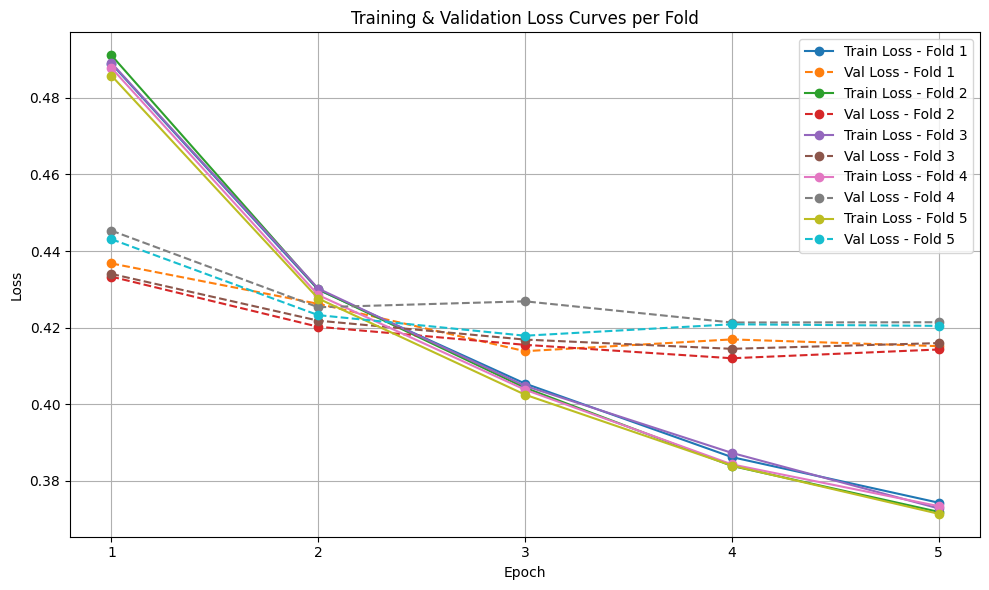


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4889         0.4368         
1     2       0.4299         0.4262         
1     3       0.4054         0.4138         
1     4       0.3862         0.4169         
1     5       0.3743         0.4152         
--------------------------------------------------
2     1       0.4911         0.4333         
2     2       0.4300         0.4202         
2     3       0.4043         0.4155         
2     4       0.3839         0.4120         
2     5       0.3719         0.4143         
--------------------------------------------------
3     1       0.4891         0.4340         
3     2       0.4302         0.4218         
3     3       0.4048         0.4169         
3     4       0.3873         0.4145         
3     5       0.3728         0.4160         
-------------------------------------------

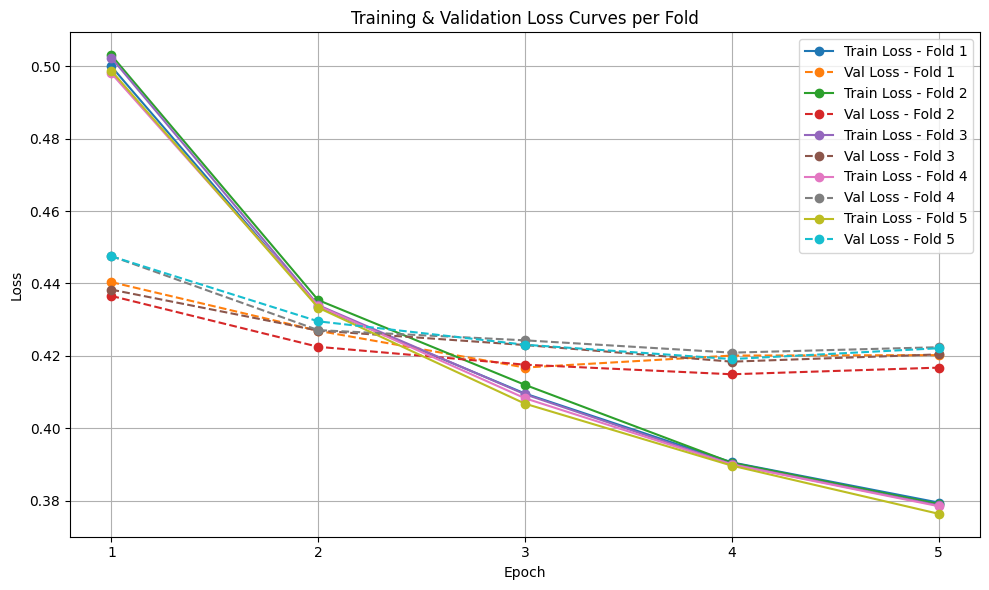


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4999         0.4404         
1     2       0.4335         0.4269         
1     3       0.4096         0.4168         
1     4       0.3906         0.4201         
1     5       0.3795         0.4202         
--------------------------------------------------
2     1       0.5030         0.4366         
2     2       0.4354         0.4225         
2     3       0.4120         0.4176         
2     4       0.3905         0.4149         
2     5       0.3791         0.4168         
--------------------------------------------------
3     1       0.5023         0.4383         
3     2       0.4340         0.4270         
3     3       0.4094         0.4230         
3     4       0.3901         0.4184         
3     5       0.3787         0.4204         
-------------------------------------------

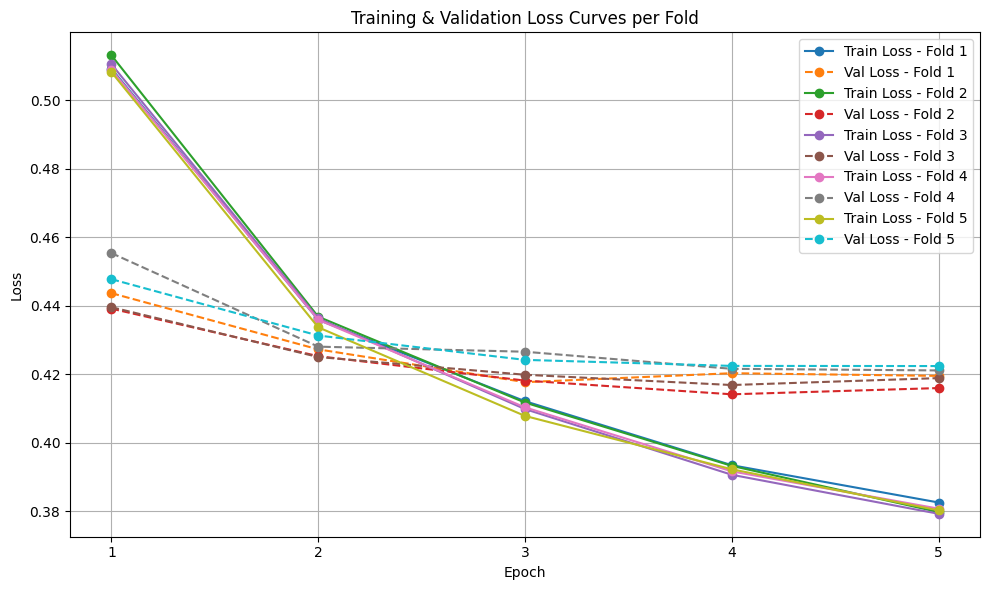


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.5093         0.4437         
1     2       0.4359         0.4273         
1     3       0.4121         0.4177         
1     4       0.3934         0.4203         
1     5       0.3825         0.4195         
--------------------------------------------------
2     1       0.5132         0.4392         
2     2       0.4368         0.4253         
2     3       0.4117         0.4181         
2     4       0.3932         0.4141         
2     5       0.3797         0.4159         
--------------------------------------------------
3     1       0.5106         0.4396         
3     2       0.4363         0.4250         
3     3       0.4098         0.4198         
3     4       0.3906         0.4168         
3     5       0.3792         0.4189         
-------------------------------------------

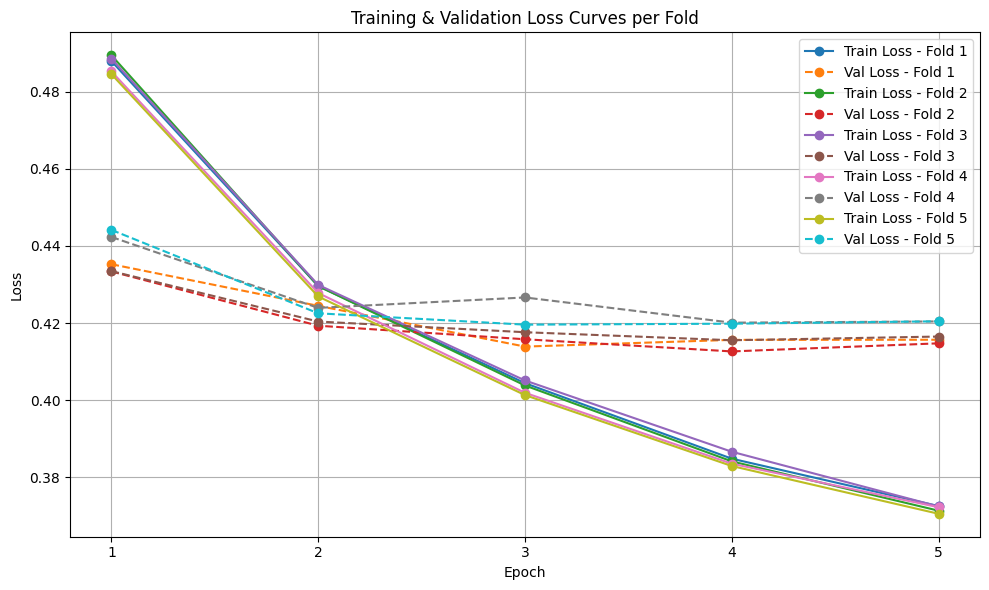


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4880         0.4353         
1     2       0.4296         0.4245         
1     3       0.4044         0.4139         
1     4       0.3848         0.4156         
1     5       0.3725         0.4157         
--------------------------------------------------
2     1       0.4895         0.4334         
2     2       0.4296         0.4193         
2     3       0.4038         0.4158         
2     4       0.3841         0.4126         
2     5       0.3713         0.4147         
--------------------------------------------------
3     1       0.4886         0.4335         
3     2       0.4299         0.4204         
3     3       0.4051         0.4176         
3     4       0.3866         0.4155         
3     5       0.3724         0.4165         
-------------------------------------------

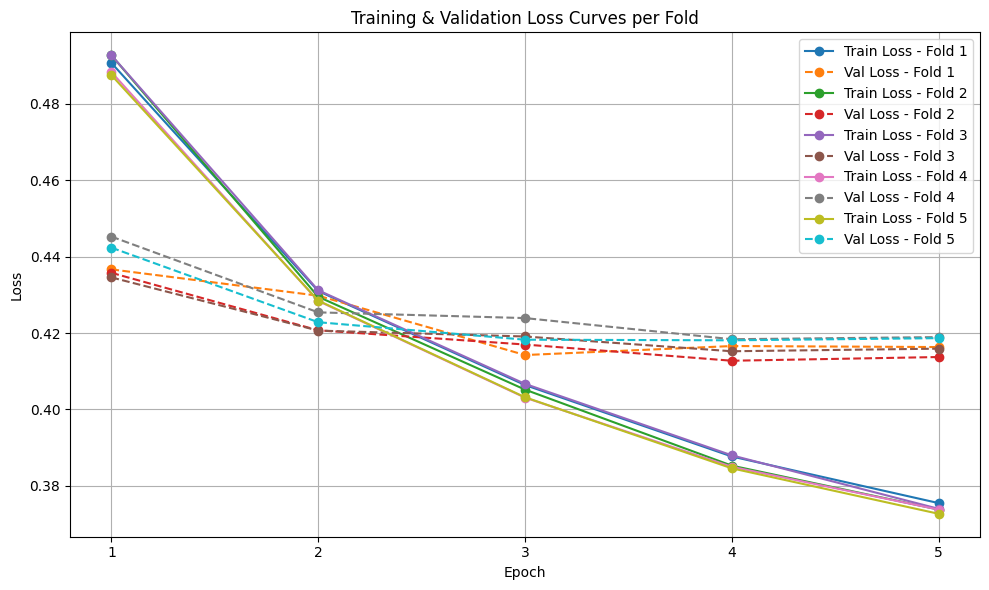


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4907         0.4367         
1     2       0.4310         0.4298         
1     3       0.4064         0.4142         
1     4       0.3877         0.4166         
1     5       0.3755         0.4163         
--------------------------------------------------
2     1       0.4927         0.4358         
2     2       0.4295         0.4207         
2     3       0.4052         0.4170         
2     4       0.3853         0.4128         
2     5       0.3738         0.4137         
--------------------------------------------------
3     1       0.4927         0.4346         
3     2       0.4312         0.4206         
3     3       0.4067         0.4191         
3     4       0.3880         0.4152         
3     5       0.3740         0.4159         
-------------------------------------------

In [ ]:
# Plot training and validation loss curves per fold
plot_loss_per_fold(fold_results_pretrained_model)

for experiment_name, experiment_results in fold_results_custom_model.items():
    print(f"\nPlotting results for experiment: {experiment_name}\n")
    plot_loss_per_fold(experiment_results)

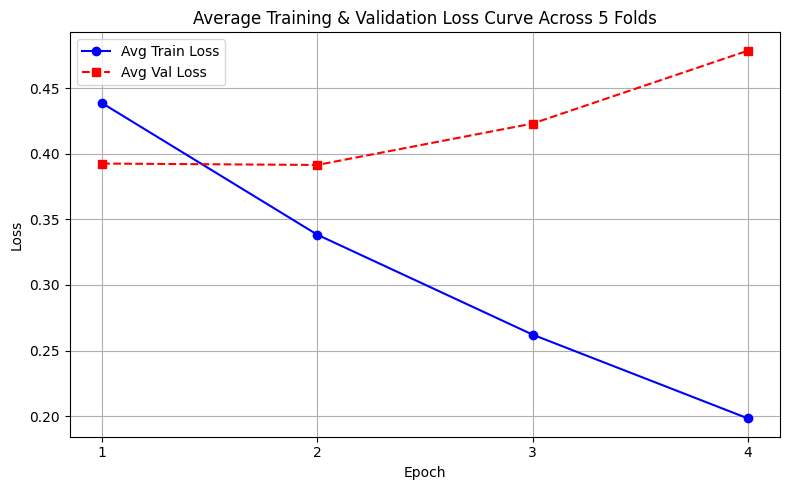


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4385          0.3925          
2       0.3383          0.3915          
3       0.2621          0.4230          
4       0.1983          0.4786          

Plotting results for experiment: baseline



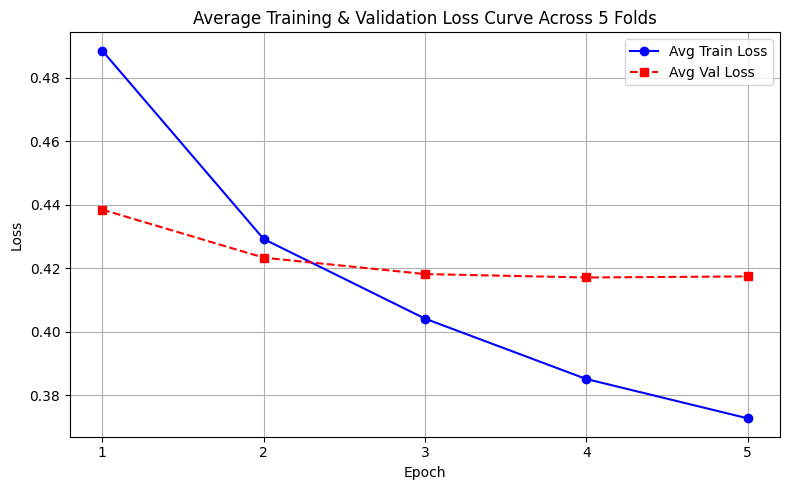


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4885          0.4385          
2       0.4292          0.4234          
3       0.4042          0.4182          
4       0.3851          0.4171          
5       0.3728          0.4175          

Plotting results for experiment: medium



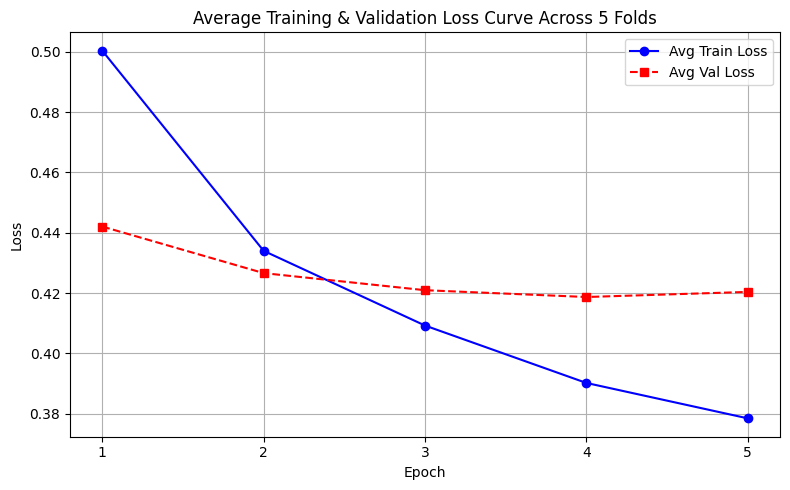


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.5004          0.4421          
2       0.4340          0.4266          
3       0.4092          0.4209          
4       0.3902          0.4187          
5       0.3784          0.4204          

Plotting results for experiment: deep



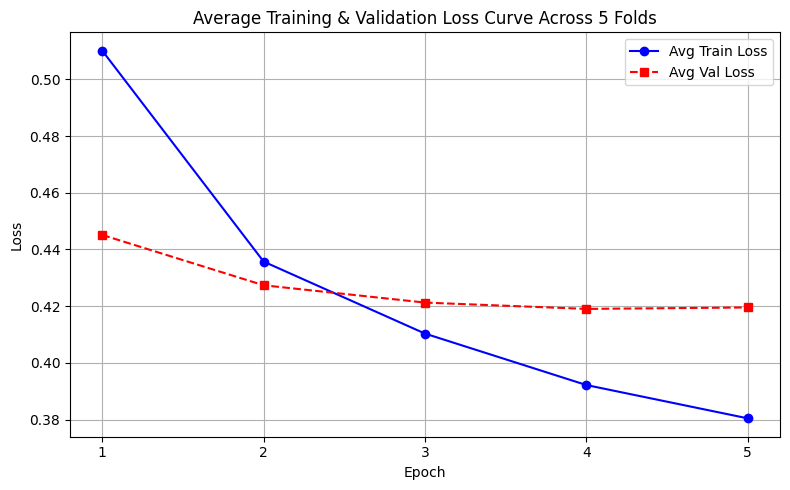


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.5101          0.4451          
2       0.4357          0.4274          
3       0.4103          0.4213          
4       0.3922          0.4190          
5       0.3805          0.4196          

Plotting results for experiment: wide



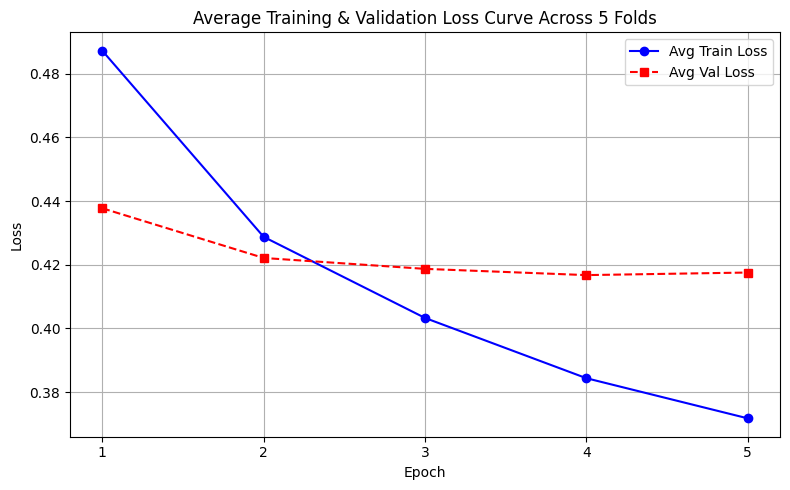


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4872          0.4377          
2       0.4288          0.4221          
3       0.4033          0.4187          
4       0.3844          0.4168          
5       0.3718          0.4176          

Plotting results for experiment: shallow



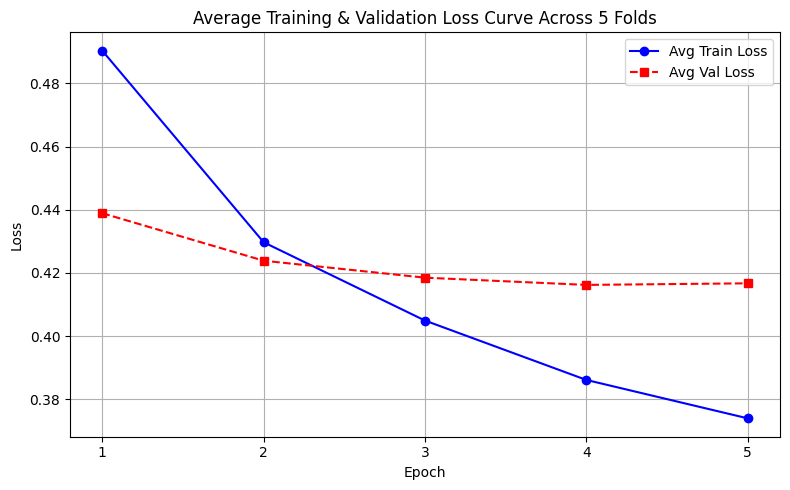


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4904          0.4389          
2       0.4297          0.4239          
3       0.4049          0.4185          
4       0.3861          0.4162          
5       0.3740          0.4167          


In [ ]:
# Plot average training and validation loss curves for 5-fold
plot_avg_loss_across_folds(fold_results_pretrained_model)

for experiment_name, experiment_results in fold_results_custom_model.items():
    print(f"\nPlotting results for experiment: {experiment_name}\n")
    plot_avg_loss_across_folds(experiment_results)

---
# **3.3 Final Model Training**

## Define Final Training Arguments

In [ ]:
def create_final_training_args(model_loader):
    training_args = TrainingArguments(
        output_dir=f"./final_results_{model_loader.__name__}",   # Directory to store checkpoints
        do_train=True,
        report_to="none",                                        # Disable external logging (e.g., WandB)
        eval_strategy="no",                                      # No evaluation during training
        save_strategy="no",                                      # Do not save at each epoch
        per_device_train_batch_size=8,
        num_train_epochs=5,
        learning_rate=3e-5,
        weight_decay=0.01,
        fp16=True,                                               # Enable mixed precision
        gradient_accumulation_steps=16,                          # Accumulate gradients
        logging_dir=f"./final_logs_{model_loader.__name__}",     # Directory for training logs
        logging_strategy="epoch",                                # Log training loss once per epoch
        seed=42                                                  # For reproducibility
    )
    return training_args

## Model Training

In [ ]:
def train_final_model(train_dataset, training_args, model_loader):

    # Train the final model on the full training dataset

    # Load the model using the helper function
    model = model_loader()
    model.to(device)

    # Initialize the Trainer for final training
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics  # Metrics won't be computed during training since evaluation is disabled
    )

    # Start training the final model
    trainer.train()

    return trainer, model

In [ ]:
# Prepare the full training dataset
full_train_dataset = prepare_dataset(x_train, y_train)

Map:   0%|          | 0/79276 [00:00<?, ? examples/s]

In [ ]:
# Train the final model using pretrained DistilBert
model_loader = load_pretrained_model
training_args = create_final_training_args(model_loader)
final_pretrained_trainer, final_pretrained_model = train_final_model(full_train_dataset, training_args, model_loader)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-31-e6ccdbd24bf5>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
620,0.431200
1240,0.332300
1860,0.258300
2480,0.193500
3095,0.154100


In [ ]:
best_exp_name = None
best_f1 = -np.inf

print("Average Metrics for Each Experiment:")
for name, results in fold_results_custom_model.items():
    # Extract F1 scores from each fold's average metrics
    f1s = [fold["avg_epoch_metrics"].get("eval_f1", np.nan) for fold in results]
    avg_f1 = np.nanmean(f1s)
    print(f"{name:<10} | Avg F1: {avg_f1:.4f}")

    if avg_f1 > best_f1:
        best_f1 = avg_f1
        best_exp_name = name

# Retrieve the best hidden_units configuration from experiments list
best_hidden_units = None
for exp in experiments:
    if exp["name"] == best_exp_name:
        best_hidden_units = exp["hidden_units"]
        break

print(f"\nBest configuration: {best_exp_name} with hidden_units: {best_hidden_units} and avg F1: {best_f1:.4f}")

# Train the final model using custom DistilBert
model_loader = lambda: load_custom_model(hidden_units=best_hidden_units, dropout_rate=0.3, activation=nn.ReLU)
training_args = create_final_training_args(model_loader)
final_custom_trainer, final_custom_model = train_final_model(full_train_dataset, training_args, model_loader)

Average Metrics for Each Experiment:
baseline   | Avg F1: 0.8081
medium     | Avg F1: 0.8078
deep       | Avg F1: 0.8073
wide       | Avg F1: 0.8083
shallow    | Avg F1: 0.8072

Best configuration: wide with hidden_units: [512] and avg F1: 0.8083


<ipython-input-31-e6ccdbd24bf5>:10: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
620,0.478700
1240,0.421000
1860,0.396900
2480,0.378000
3095,0.364900


---
# **3.4 Final Model Evaluation**

In [ ]:
def evaluate_final_model(trainer, eval_dataset):
    final_test_results = trainer.evaluate(eval_dataset)

    # Extract key metrics
    eval_loss = final_test_results.get("eval_loss", "N/A")
    eval_accuracy = final_test_results.get("eval_accuracy", "N/A")
    eval_precision = final_test_results.get("eval_precision", "N/A")
    eval_recall = final_test_results.get("eval_recall", "N/A")
    eval_f1 = final_test_results.get("eval_f1", "N/A")

    print("\nFinal Model Evaluation on the Test Set:")
    print("-" * 50)
    print(f"{'Metric':<15}{'Value':>10}")
    print("-" * 50)
    print(f"{'Accuracy':<15}{eval_accuracy:.4f} ({eval_accuracy * 100:.2f}%)")
    print(f"{'Precision':<15}{eval_precision:.4f} ({eval_precision * 100:.2f}%)")
    print(f"{'Recall':<15}{eval_recall:.4f} ({eval_recall * 100:.2f}%)")
    print(f"{'F1 Score':<15}{eval_f1:.4f} ({eval_f1 * 100:.2f}%)")
    print(f"{'Loss':<15}{eval_loss:.4f}")
    print("-" * 50)

    return final_test_results

In [ ]:
# Prepare the test set
test_dataset = prepare_dataset(x_test, y_test)

Map:   0%|          | 0/19819 [00:00<?, ? examples/s]

In [ ]:
# Evaluate the final model using pretrained DistilBert
evaluate_final_model(final_pretrained_trainer, test_dataset)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8231 (82.31%)
Precision      0.8232 (82.32%)
Recall         0.8231 (82.31%)
F1 Score       0.8231 (82.31%)
Loss           0.5372
--------------------------------------------------


{'eval_loss': 0.537164032459259,
 'eval_accuracy': 0.8230990463696453,
 'eval_precision': 0.823235194852964,
 'eval_recall': 0.8230990463696453,
 'eval_f1': 0.8230865993932794,
 'eval_runtime': 22.3357,
 'eval_samples_per_second': 887.324,
 'eval_steps_per_second': 110.943,
 'epoch': 4.992936427850656}

In [ ]:
# Evaluate the final model using custom DistilBert
evaluate_final_model(final_custom_trainer, test_dataset)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8167 (81.67%)
Precision      0.8170 (81.70%)
Recall         0.8167 (81.67%)
F1 Score       0.8167 (81.67%)
Loss           0.4133
--------------------------------------------------


{'eval_loss': 0.4132700264453888,
 'eval_accuracy': 0.8166910540390534,
 'eval_precision': 0.8169909980801561,
 'eval_recall': 0.8166910540390534,
 'eval_f1': 0.8166575068020605,
 'eval_runtime': 21.7824,
 'eval_samples_per_second': 909.861,
 'eval_steps_per_second': 113.761,
 'epoch': 4.992936427850656}

---
# **3.5 Final Model Prediction**

## Predict, Compute and Print Evaluation Metrics

In [ ]:
def predict_final_model_with_metrics(trainer, eval_dataset, output_dir=None, class_labels=None):
    predictions = trainer.predict(eval_dataset)
    preds = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids

    # Compute metrics
    accuracy = accuracy_score(true_labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, preds, average='weighted')

    # Confusion matrix
    cm = confusion_matrix(true_labels, preds)

    # Classification report (per class)
    if class_labels:
        report = classification_report(true_labels, preds, target_names=class_labels, digits=4, output_dict=True)
        report_text = classification_report(true_labels, preds, target_names=class_labels, digits=4)
    else:
        report = classification_report(true_labels, preds, digits=4, output_dict=True)
        report_text = classification_report(true_labels, preds, digits=4)

    # Print summary of metrics
    print("\nFinal Model Predictions Summary")
    print("-" * 50)
    print(f"{'Metric':<15}{'Value':>10}")
    print("-" * 50)
    print(f"{'Accuracy':<15}{accuracy:.4f} ({accuracy * 100:.2f}%)")
    print(f"{'Precision':<15}{precision:.4f} ({precision * 100:.2f}%)")
    print(f"{'Recall':<15}{recall:.4f} ({recall * 100:.2f}%)")
    print(f"{'F1 Score':<15}{f1:.4f} ({f1 * 100:.2f}%)")
    print("-" * 50)

    print("\nClassification Report (Per Class):")
    print(report_text)

    print("\nConfusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.tight_layout()

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(f"{output_dir}/confusion_matrix.png")
        print(f"\nConfusion matrix saved to {output_dir}/confusion_matrix.png\n")
    plt.show()

    metrics = {
        "eval_accuracy": accuracy,
        "eval_precision": precision,
        "eval_recall": recall,
        "eval_f1": f1
    }

    return metrics, cm, preds, true_labels


Final Model Predictions Summary
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8231 (82.31%)
Precision      0.8232 (82.32%)
Recall         0.8231 (82.31%)
F1 Score       0.8231 (82.31%)
--------------------------------------------------

Classification Report (Per Class):
              precision    recall  f1-score   support

    Negative     0.8163    0.8325    0.8243      9882
    Positive     0.8301    0.8137    0.8218      9937

    accuracy                         0.8231     19819
   macro avg     0.8232    0.8231    0.8231     19819
weighted avg     0.8232    0.8231    0.8231     19819


Confusion Matrix:
[[8227 1655]
 [1851 8086]]

Confusion matrix saved to ./1_Initial_Pretrained_Model_Cleaned_And_Removed_Dups_Tweets/confusion_matrix.png



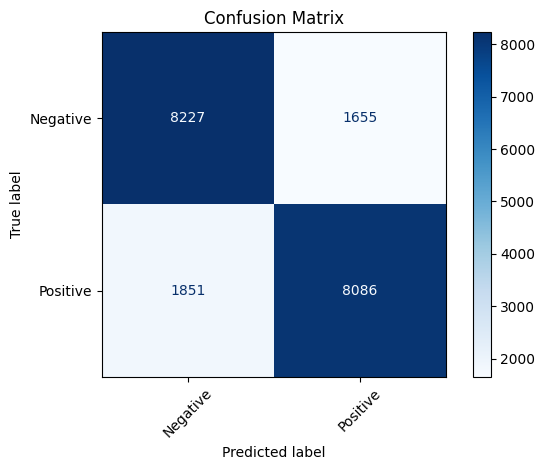

In [ ]:
model_name = "1_Initial_Pretrained_Model_Cleaned_And_Removed_Dups_Tweets"

# Get predictions, metrics from confusion matrix and save visualization
prediction_metrics, cm, preds, labels = predict_final_model_with_metrics(
    final_pretrained_trainer,
    test_dataset,
    output_dir=f"./{model_name}",
    class_labels=["Negative", "Positive"]
)


Final Model Predictions Summary
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8167 (81.67%)
Precision      0.8170 (81.70%)
Recall         0.8167 (81.67%)
F1 Score       0.8167 (81.67%)
--------------------------------------------------

Classification Report (Per Class):
              precision    recall  f1-score   support

    Negative     0.8070    0.8312    0.8189      9882
    Positive     0.8270    0.8023    0.8144      9937

    accuracy                         0.8167     19819
   macro avg     0.8170    0.8167    0.8167     19819
weighted avg     0.8170    0.8167    0.8167     19819


Confusion Matrix:
[[8214 1668]
 [1965 7972]]

Confusion matrix saved to ./1_Initial_Custom_Model_Cleaned_And_Removed_Dups_Tweets/confusion_matrix.png



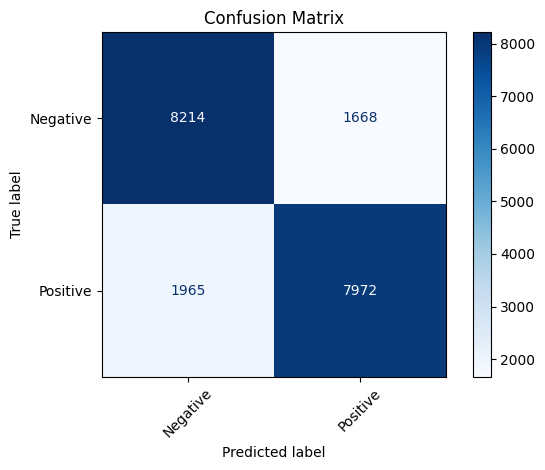

In [ ]:
model_name = "1_Initial_Custom_Model_Cleaned_And_Removed_Dups_Tweets"

# Get predictions, metrics from confusion matrix and save visualization
prediction_metrics, cm, preds, labels = predict_final_model_with_metrics(
    final_custom_trainer,
    test_dataset,
    output_dir=f"./{model_name}",
    class_labels=["Negative", "Positive"]
)

---
# **3.6 Save Final Model**

**Note**: If you are running this code chunk, please change the `drive_base_path` to `"/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/DistilBERT"`. If not, you may access the saved model in the `Trained Model Links` file.

In [ ]:
def save_model_to_drive(model, tokenizer, model_name, metrics=None):

    # Mount Google Drive
    drive.mount("/content/drive", force_remount=True)

    # Paths
    local_path = f"./{model_name}"
    drive_base_path = "/content/drive/My Drive/Colab Notebooks/IT1244 Project/Saved Model" # or change to "/content/drive/My Drive/IT1244_Team1_Project/Model & Dataset/DistilBERT"
    drive_path = os.path.join(drive_base_path, model_name)

    # Create local directory if it doesn't exist
    if not os.path.exists(local_path):
        os.makedirs(local_path)

    # Save the model and tokenizer locally
    # Check if the model is an instance of a Hugging Face PreTrainedModel
    if isinstance(model, torch.nn.Module):
        # Save the model's state_dict instead of using save_pretrained
        torch.save(model.state_dict(), os.path.join(local_path, "model_state_dict.pth"))
    else:
        model.save_pretrained(local_path)

    tokenizer.save_pretrained(local_path)

    # Save metrics to local folder
    if metrics:
        with open(os.path.join(local_path, "metrics.json"), "w") as f:
            json.dump(metrics, f, indent=4)

    # Remove old copy in Google Drive (if exists)
    if os.path.exists(drive_path):
        try:
            shutil.rmtree(drive_path)
        except Exception as e:
            print(f"Error removing existing folder {drive_path}: {e}")

    # Copy local folder to Google Drive
    try:
        shutil.copytree(local_path, drive_path)
        print(f"Model and metrics saved to Google Drive at: {drive_path}")
    except Exception as e:
        print(f"Error copying model to Google Drive: {e}")

In [ ]:
model_name = "1_Initial_Pretrained_Model_Cleaned_And_Removed_Dups_Tweets"
final_model_eval_metrics = evaluate_final_model(final_pretrained_trainer, test_dataset)
metrics1 = {
    "trainer_evaluation": final_model_eval_metrics,
    "confusion_matrix_metrics": prediction_metrics
}
save_model_to_drive(final_pretrained_model, tokenizer, model_name, metrics=metrics1)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8231 (82.31%)
Precision      0.8232 (82.32%)
Recall         0.8231 (82.31%)
F1 Score       0.8231 (82.31%)
Loss           0.5372
--------------------------------------------------
Mounted at /content/drive
Model and metrics saved to Google Drive at: /content/drive/My Drive/Colab Notebooks/IT1244 Project/Saved Model/1_Initial_Pretrained_Model_Cleaned_And_Removed_Dups_Tweets


In [ ]:
model_name = "1_Initial_Custom_Model_Cleaned_And_Removed_Dups_Tweets"
final_model_eval_metrics = evaluate_final_model(final_custom_trainer, test_dataset)
metrics2 = {
    "trainer_evaluation": final_model_eval_metrics,
    "confusion_matrix_metrics": prediction_metrics
}
save_model_to_drive(final_custom_model, tokenizer, model_name, metrics=metrics2)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8167 (81.67%)
Precision      0.8170 (81.70%)
Recall         0.8167 (81.67%)
F1 Score       0.8167 (81.67%)
Loss           0.4133
--------------------------------------------------
Mounted at /content/drive
Model and metrics saved to Google Drive at: /content/drive/My Drive/Colab Notebooks/IT1244 Project/Saved Model/1_Initial_Custom_Model_Cleaned_And_Removed_Dups_Tweets


---
# **4. Hyperparameter Fine-Tuning Using Optuna**

---
# **4.1 Fine-Tuned Model Training & Evaluation**

## Helper Function: Run just the first fold

In [ ]:
def run_first_fold(x_train, y_train, training_args, model_loader):
    # Create a StratifiedKFold object with 5 splits
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Loop over the folds, but break after the first one
    for fold, (train_idx, val_idx) in enumerate(kfold.split(x_train, y_train)):
        print(f"\nRunning Fold {fold + 1}/1 (only the first fold will be used)")

        # Split data for this fold
        fold_x_train, fold_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
        fold_y_train, fold_y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Train and evaluate on this fold
        result = run_fold(fold, fold_x_train, fold_y_train, fold_x_val, fold_y_val, training_args, model_loader)

        # Return the result of the first fold and exit
        return result

## Define Base Training Arguments for Hyperparameter Search

In [ ]:
def create_base_training_args(
    model_loader,
    learning_rate,
    batch_size,
    grad_acc,
    weight_decay,
    warmup_steps,
    max_grad_norm,
    adam_epsilon,
    scheduler_choice
):
    return TrainingArguments(
        output_dir=f"./base_results_{model_loader.__name__}",
        report_to="none",
        eval_strategy="epoch",
        save_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=5,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        fp16=True,
        gradient_accumulation_steps=grad_acc,
        logging_dir=f"./base_logs_{model_loader.__name__}",
        logging_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True,
        seed=42,
        warmup_steps=warmup_steps,
        max_grad_norm=max_grad_norm,
        adam_epsilon=adam_epsilon,
        lr_scheduler_type=scheduler_choice
    )

## Objective for Optuna

In [ ]:
def optuna_objective_distilbert(trial):
    # Training hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    grad_acc = trial.suggest_categorical("grad_acc", [1, 4, 8, 16])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
    warmup_steps = trial.suggest_int("warmup_steps", 0, 500)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 2.0)
    adam_epsilon = trial.suggest_float("adam_epsilon", 1e-8, 1e-6, log=True)
    scheduler_choice = trial.suggest_categorical("scheduler", ["linear", "cosine", "constant"])

    model_loader = load_pretrained_model

    # Update training arguments with trial-suggested values
    training_args = create_base_training_args(
        model_loader=model_loader,
        learning_rate=learning_rate,
        batch_size=batch_size,
        grad_acc=grad_acc,
        weight_decay=weight_decay,
        warmup_steps=warmup_steps,
        max_grad_norm=max_grad_norm,
        adam_epsilon=adam_epsilon,
        scheduler_choice=scheduler_choice
    )

    # Run only the first fold for quicker evaluation
    result = run_first_fold(x_train, y_train, training_args, model_loader)

    # Extract average evaluation metrics from the first fold
    avg_metrics = result["avg_epoch_metrics"]
    print("\nTrial Summary:")
    for metric, value in avg_metrics.items():
        print(f"{metric:<15}: {value:.4f}")

    # Store metrics for further analysis
    trial.set_user_attr("metrics", avg_metrics)

    # Return F1 as the objective metric to maximize
    return avg_metrics["eval_f1"]

In [ ]:
def optuna_objective_custom_model(trial):
    # Architecture parameters
    n_layers = trial.suggest_int("n_layers", 1, 3)
    hidden_units = [trial.suggest_categorical(f"hidden_size_{i}", [64, 128, 256, 512])
                    for i in range(n_layers)]

    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    activation_choice = trial.suggest_categorical("activation", ["relu", "gelu", "tanh"])

    # Training hyperparameters
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    grad_acc = trial.suggest_categorical("grad_acc", [1, 4, 8, 16])
    weight_decay = trial.suggest_float("weight_decay", 0.0, 0.3)
    warmup_steps = trial.suggest_int("warmup_steps", 0, 500)
    max_grad_norm = trial.suggest_float("max_grad_norm", 0.5, 2.0)
    adam_epsilon = trial.suggest_float("adam_epsilon", 1e-8, 1e-6, log=True)
    scheduler_choice = trial.suggest_categorical("scheduler", ["linear", "cosine", "constant"])

    # Map activation function string to torch.nn module
    activation_map = {
        "relu": nn.ReLU,
        "gelu": nn.GELU,
        "tanh": nn.Tanh
    }

    # Model loader using the current trial's architecture parameters
    model_loader = lambda: load_custom_model(
        hidden_units=hidden_units,
        dropout_rate=dropout_rate,
        activation=activation_map[activation_choice]
    )

    # Update training arguments with trial-suggested values
    training_args = create_base_training_args(
        model_loader=model_loader,
        learning_rate=learning_rate,
        batch_size=batch_size,
        grad_acc=grad_acc,
        weight_decay=weight_decay,
        warmup_steps=warmup_steps,
        max_grad_norm=max_grad_norm,
        adam_epsilon=adam_epsilon,
        scheduler_choice=scheduler_choice
    )

    # Run only the first fold for quicker evaluation
    result = run_first_fold(x_train, y_train, training_args, model_loader)

    # Extract average evaluation metrics from the first fold
    avg_metrics = result["avg_epoch_metrics"]
    print("\nTrial Summary:")
    for metric, value in avg_metrics.items():
        print(f"{metric:<15}: {value:.4f}")

    # Store metrics for further analysis
    trial.set_user_attr("metrics", avg_metrics)

    # Return F1 as the objective metric to maximize
    return avg_metrics["eval_f1"]

**WARNING**: Running the below code chunk will take approximately 3 hours on GPU

In [ ]:
# Run Optuna Study for Pretrained DistilBert
study1 = optuna.create_study(direction="maximize", study_name="custom_model_optuna_tuning")
study1.optimize(optuna_objective_distilbert, n_trials=15)

print("\nBest Trial:")
print(f"Best F1 Score: {study1.best_value:.4f}")
for key, value in study1.best_trial.params.items():
    print(f"{key:<25}: {value}")

[I 2025-03-31 13:48:17,465] A new study created in memory with name: custom_model_optuna_tuning



Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.435100,0.389236,0.823411,0.823732,0.823411,0.823376
2,0.326100,0.397550,0.826942,0.829987,0.826942,0.826571
3,0.227700,0.434554,0.826186,0.826199,0.826186,0.826182
4,0.145000,0.541172,0.820194,0.823299,0.820194,0.819793


[I 2025-03-31 13:52:44,785] Trial 0 finished with value: 0.8239804913333908 and parameters: {'learning_rate': 4.115045319830632e-05, 'batch_size': 32, 'grad_acc': 4, 'weight_decay': 0.08820787823010313, 'warmup_steps': 342, 'max_grad_norm': 1.3410029574883997, 'adam_epsilon': 2.5624787505075868e-08, 'scheduler': 'constant'}. Best is trial 0 with value: 0.8239804913333908.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4406
eval_accuracy            : 0.8242
eval_precision           : 0.8258
eval_recall              : 0.8242
eval_f1                  : 0.8240
eval_runtime             : 6.4901
eval_samples_per_second  : 2443.1327
eval_steps_per_second    : 76.4250

Loss History:
- Training Loss per Epoch   : ['0.4351', '0.3261', '0.2277', '0.1450']
- Validation Loss per Epoch : ['0.3892', '0.3976', '0.4346', '0.5412']
- Average Training Loss     : 0.2835
- Average Validation Loss   : 0.4406

Trial Summary:
eval_loss      : 0.4406
eval_accuracy  : 0.8242
eval_precision : 0.8258
eval_recall    : 0.8242
eval_f1        : 0.8240
eval_runtime   : 6.4901
eval_samples_per_second: 2443.1327
eval_steps_per_second: 76.4250

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.471900,0.397823,0.821203,0.821467,0.821203,0.821176
2,0.352500,0.395089,0.827573,0.829828,0.827573,0.827303
3,0.274500,0.411405,0.829907,0.830449,0.829907,0.829825
4,0.207000,0.485745,0.829087,0.829150,0.829087,0.829083
5,0.162700,0.524234,0.825177,0.825409,0.825177,0.825153


[I 2025-03-31 14:02:33,207] Trial 1 finished with value: 0.8265077159859745 and parameters: {'learning_rate': 2.0873734425939357e-05, 'batch_size': 16, 'grad_acc': 4, 'weight_decay': 0.2317586552787059, 'warmup_steps': 459, 'max_grad_norm': 1.5369472729190012, 'adam_epsilon': 2.1723641734247824e-07, 'scheduler': 'linear'}. Best is trial 1 with value: 0.8265077159859745.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4429
eval_accuracy            : 0.8266
eval_precision           : 0.8273
eval_recall              : 0.8266
eval_f1                  : 0.8265
eval_runtime             : 10.2829
eval_samples_per_second  : 1542.0728
eval_steps_per_second    : 96.3794

Loss History:
- Training Loss per Epoch   : ['0.4719', '0.3525', '0.2745', '0.2070', '0.1627']
- Validation Loss per Epoch : ['0.3978', '0.3951', '0.4114', '0.4857', '0.5242']
- Average Training Loss     : 0.2937
- Average Validation Loss   : 0.4429

Trial Summary:
eval_loss      : 0.4429
eval_accuracy  : 0.8266
eval_precision : 0.8273
eval_recall    : 0.8266
eval_f1        : 0.8265
eval_runtime   : 10.2829
eval_samples_per_second: 1542.0728
eval_steps_per_second: 96.3794

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.505700,0.415530,0.807644,0.813575,0.807644,0.806778
1,0.369500,0.383850,0.828835,0.829357,0.828835,0.828778
2,0.274500,0.408797,0.832682,0.832683,0.832682,0.832682
3,0.184200,0.488683,0.827825,0.827839,0.827825,0.827825
4,0.136700,0.533557,0.826879,0.826958,0.826879,0.826874


[I 2025-03-31 14:07:56,253] Trial 2 finished with value: 0.8245873306208052 and parameters: {'learning_rate': 4.3494988530213755e-05, 'batch_size': 32, 'grad_acc': 8, 'weight_decay': 0.18546759732927928, 'warmup_steps': 225, 'max_grad_norm': 1.9459427122115283, 'adam_epsilon': 4.914590973208247e-07, 'scheduler': 'cosine'}. Best is trial 1 with value: 0.8265077159859745.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4461
eval_accuracy            : 0.8248
eval_precision           : 0.8261
eval_recall              : 0.8248
eval_f1                  : 0.8246
eval_runtime             : 6.4783
eval_samples_per_second  : 2447.6634
eval_steps_per_second    : 76.5668

Loss History:
- Training Loss per Epoch   : ['0.5057', '0.3695', '0.2745', '0.1842', '0.1367']
- Validation Loss per Epoch : ['0.4155', '0.3839', '0.4088', '0.4887', '0.5336']
- Average Training Loss     : 0.2941
- Average Validation Loss   : 0.4461

Trial Summary:
eval_loss      : 0.4461
eval_accuracy  : 0.8248
eval_precision : 0.8261
eval_recall    : 0.8248
eval_f1        : 0.8246
eval_runtime   : 6.4783
eval_samples_per_second: 2447.6634
eval_steps_per_second: 76.5668

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.446700,0.396205,0.821077,0.821200,0.821077,0.821066
2,0.353500,0.394302,0.825618,0.828438,0.825618,0.825271
3,0.287100,0.406366,0.827825,0.828097,0.827825,0.827781
4,0.158900,0.536699,0.823285,0.823742,0.823285,0.823210


[I 2025-03-31 14:17:29,798] Trial 3 finished with value: 0.8241378269133859 and parameters: {'learning_rate': 2.0708387318349687e-05, 'batch_size': 16, 'grad_acc': 8, 'weight_decay': 0.035385671675982035, 'warmup_steps': 128, 'max_grad_norm': 0.5311786707520867, 'adam_epsilon': 3.333292437218478e-08, 'scheduler': 'constant'}. Best is trial 1 with value: 0.8265077159859745.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4397
eval_accuracy            : 0.8243
eval_precision           : 0.8255
eval_recall              : 0.8243
eval_f1                  : 0.8241
eval_runtime             : 10.3121
eval_samples_per_second  : 1537.6660
eval_steps_per_second    : 96.1042

Loss History:
- Training Loss per Epoch   : ['0.4467', '0.3535', '0.2871', '0.2186', '0.1589']
- Validation Loss per Epoch : ['0.3962', '0.3943', '0.4064', '0.4649', '0.5367']
- Average Training Loss     : 0.2930
- Average Validation Loss   : 0.4397

Trial Summary:
eval_loss      : 0.4397
eval_accuracy  : 0.8243
eval_precision : 0.8255
eval_recall    : 0.8243
eval_f1        : 0.8241
eval_runtime   : 10.3121
eval_samples_per_second: 1537.6660
eval_steps_per_second: 96.1042

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.445800,0.391111,0.822717,0.822785,0.822717,0.822712
2,0.317400,0.407529,0.829465,0.829579,0.829465,0.829456
3,0.186900,0.492326,0.824735,0.824869,0.824735,0.824723
4,0.100300,0.783372,0.822717,0.822828,0.822717,0.822696


[I 2025-03-31 14:22:33,750] Trial 4 finished with value: 0.8248966301193731 and parameters: {'learning_rate': 4.3686792577697e-05, 'batch_size': 32, 'grad_acc': 1, 'weight_decay': 0.28722042425944405, 'warmup_steps': 311, 'max_grad_norm': 0.8480777597349052, 'adam_epsilon': 1.3531246256226036e-07, 'scheduler': 'cosine'}. Best is trial 1 with value: 0.8265077159859745.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.5186
eval_accuracy            : 0.8249
eval_precision           : 0.8250
eval_recall              : 0.8249
eval_f1                  : 0.8249
eval_runtime             : 6.4836
eval_samples_per_second  : 2445.6312
eval_steps_per_second    : 76.5033

Loss History:
- Training Loss per Epoch   : ['0.4458', '0.3174', '0.1869', '0.1003']
- Validation Loss per Epoch : ['0.3911', '0.4075', '0.4923', '0.7834']
- Average Training Loss     : 0.2626
- Average Validation Loss   : 0.5186

Trial Summary:
eval_loss      : 0.5186
eval_accuracy  : 0.8249
eval_precision : 0.8250
eval_recall    : 0.8249
eval_f1        : 0.8249
eval_runtime   : 6.4836
eval_samples_per_second: 2445.6312
eval_steps_per_second: 76.5033

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.474200,0.467341,0.810671,0.812037,0.810671,0.810486
2,0.378100,0.486596,0.813698,0.815447,0.813698,0.813464
3,0.300300,0.694882,0.812185,0.812853,0.812185,0.812100
4,0.208600,0.834376,0.811743,0.814091,0.811743,0.811420


[I 2025-03-31 14:39:14,378] Trial 5 finished with value: 0.8118674398298782 and parameters: {'learning_rate': 4.977131041225138e-05, 'batch_size': 8, 'grad_acc': 1, 'weight_decay': 0.12631638849054205, 'warmup_steps': 266, 'max_grad_norm': 1.2329103156977501, 'adam_epsilon': 1.0093873958134739e-07, 'scheduler': 'linear'}. Best is trial 1 with value: 0.8265077159859745.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.6208
eval_accuracy            : 0.8121
eval_precision           : 0.8136
eval_recall              : 0.8121
eval_f1                  : 0.8119
eval_runtime             : 17.8697
eval_samples_per_second  : 887.3375
eval_steps_per_second    : 110.9170

Loss History:
- Training Loss per Epoch   : ['0.4742', '0.3781', '0.3003', '0.2086']
- Validation Loss per Epoch : ['0.4673', '0.4866', '0.6949', '0.8344']
- Average Training Loss     : 0.3403
- Average Validation Loss   : 0.6208

Trial Summary:
eval_loss      : 0.6208
eval_accuracy  : 0.8121
eval_precision : 0.8136
eval_recall    : 0.8121
eval_f1        : 0.8119
eval_runtime   : 17.8697
eval_samples_per_second: 887.3375
eval_steps_per_second: 110.9170

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.457400,0.397437,0.820383,0.820403,0.820383,0.820383
2,0.361500,0.396071,0.825492,0.828040,0.825492,0.825179
3,0.309200,0.396046,0.830033,0.830069,0.830033,0.830025
4,0.264000,0.436074,0.828078,0.828171,0.828078,0.828070
5,0.234600,0.445634,0.827510,0.827625,0.827510,0.827500


[I 2025-03-31 14:49:06,141] Trial 6 finished with value: 0.8262315420012648 and parameters: {'learning_rate': 1.3466810595057187e-05, 'batch_size': 16, 'grad_acc': 4, 'weight_decay': 0.27082033819566154, 'warmup_steps': 107, 'max_grad_norm': 0.5118214428087929, 'adam_epsilon': 5.3073324873766285e-08, 'scheduler': 'linear'}. Best is trial 1 with value: 0.8265077159859745.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4143
eval_accuracy            : 0.8263
eval_precision           : 0.8269
eval_recall              : 0.8263
eval_f1                  : 0.8262
eval_runtime             : 10.2635
eval_samples_per_second  : 1544.9190
eval_steps_per_second    : 96.5576

Loss History:
- Training Loss per Epoch   : ['0.4574', '0.3615', '0.3092', '0.2640', '0.2346']
- Validation Loss per Epoch : ['0.3974', '0.3961', '0.3960', '0.4361', '0.4456']
- Average Training Loss     : 0.3253
- Average Validation Loss   : 0.4143

Trial Summary:
eval_loss      : 0.4143
eval_accuracy  : 0.8263
eval_precision : 0.8269
eval_recall    : 0.8263
eval_f1        : 0.8262
eval_runtime   : 10.2635
eval_samples_per_second: 1544.9190
eval_steps_per_second: 96.5576

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.444800,0.394175,0.823852,0.823853,0.823852,0.823852
2,0.310100,0.416738,0.826501,0.827091,0.826501,0.826435
3,0.186600,0.503046,0.824104,0.824105,0.824104,0.824104
4,0.104700,0.711918,0.821266,0.821306,0.821266,0.821264


[I 2025-03-31 14:54:10,940] Trial 7 finished with value: 0.8239139013965296 and parameters: {'learning_rate': 4.8101313986883625e-05, 'batch_size': 32, 'grad_acc': 1, 'weight_decay': 0.011714249976979285, 'warmup_steps': 272, 'max_grad_norm': 1.1814584083987423, 'adam_epsilon': 9.39440554788332e-08, 'scheduler': 'linear'}. Best is trial 1 with value: 0.8265077159859745.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.5065
eval_accuracy            : 0.8239
eval_precision           : 0.8241
eval_recall              : 0.8239
eval_f1                  : 0.8239
eval_runtime             : 6.4684
eval_samples_per_second  : 2451.3562
eval_steps_per_second    : 76.6820

Loss History:
- Training Loss per Epoch   : ['0.4448', '0.3101', '0.1866', '0.1047']
- Validation Loss per Epoch : ['0.3942', '0.4167', '0.5030', '0.7119']
- Average Training Loss     : 0.2615
- Average Validation Loss   : 0.5065

Trial Summary:
eval_loss      : 0.5065
eval_accuracy  : 0.8239
eval_precision : 0.8241
eval_recall    : 0.8239
eval_f1        : 0.8239
eval_runtime   : 6.4684
eval_samples_per_second: 2451.3562
eval_steps_per_second: 76.6820

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.443700,0.411431,0.821834,0.822833,0.821834,0.821713
2,0.349800,0.473809,0.821140,0.823870,0.821140,0.820791
3,0.278200,0.599652,0.822969,0.823198,0.822969,0.822946
4,0.210500,0.781082,0.816662,0.817484,0.816662,0.816560
5,0.163900,0.891336,0.820257,0.820275,0.820257,0.820252


[I 2025-03-31 15:15:03,748] Trial 8 finished with value: 0.8204526192118695 and parameters: {'learning_rate': 1.6046641305352344e-05, 'batch_size': 8, 'grad_acc': 1, 'weight_decay': 0.05994819468759949, 'warmup_steps': 494, 'max_grad_norm': 1.6765744264975933, 'adam_epsilon': 1.5163497786699756e-07, 'scheduler': 'constant'}. Best is trial 1 with value: 0.8265077159859745.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.6315
eval_accuracy            : 0.8206
eval_precision           : 0.8215
eval_recall              : 0.8206
eval_f1                  : 0.8205
eval_runtime             : 17.8705
eval_samples_per_second  : 887.2732
eval_steps_per_second    : 110.9092

Loss History:
- Training Loss per Epoch   : ['0.4437', '0.3498', '0.2782', '0.2105', '0.1639']
- Validation Loss per Epoch : ['0.4114', '0.4738', '0.5997', '0.7811', '0.8913']
- Average Training Loss     : 0.2892
- Average Validation Loss   : 0.6315

Trial Summary:
eval_loss      : 0.6315
eval_accuracy  : 0.8206
eval_precision : 0.8215
eval_recall    : 0.8206
eval_f1        : 0.8205
eval_runtime   : 17.8705
eval_samples_per_second: 887.2732
eval_steps_per_second: 110.9092

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.516500,0.409334,0.813005,0.813217,0.813005,0.812964
1,0.382500,0.397117,0.824357,0.825637,0.824357,0.824164
2,0.334900,0.399765,0.827573,0.828149,0.827573,0.827485
3,0.297000,0.404994,0.829024,0.829035,0.829024,0.829024
4,0.269500,0.414815,0.829213,0.829390,0.829213,0.829197


[I 2025-03-31 15:20:22,269] Trial 9 finished with value: 0.8245666280572852 and parameters: {'learning_rate': 2.8192310197333664e-05, 'batch_size': 32, 'grad_acc': 16, 'weight_decay': 0.09503931079109108, 'warmup_steps': 38, 'max_grad_norm': 1.6352121385232001, 'adam_epsilon': 1.0009091626001026e-08, 'scheduler': 'linear'}. Best is trial 1 with value: 0.8265077159859745.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4052
eval_accuracy            : 0.8246
eval_precision           : 0.8251
eval_recall              : 0.8246
eval_f1                  : 0.8246
eval_runtime             : 6.5020
eval_samples_per_second  : 2438.7084
eval_steps_per_second    : 76.2866

Loss History:
- Training Loss per Epoch   : ['0.5165', '0.3825', '0.3349', '0.2970', '0.2695']
- Validation Loss per Epoch : ['0.4093', '0.3971', '0.3998', '0.4050', '0.4148']
- Average Training Loss     : 0.3601
- Average Validation Loss   : 0.4052

Trial Summary:
eval_loss      : 0.4052
eval_accuracy  : 0.8246
eval_precision : 0.8251
eval_recall    : 0.8246
eval_f1        : 0.8246
eval_runtime   : 6.5020
eval_samples_per_second: 2438.7084
eval_steps_per_second: 76.2866

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.492500,0.406277,0.815780,0.815788,0.815780,0.815776
2,0.377000,0.399071,0.821582,0.824651,0.821582,0.821189
3,0.328500,0.393039,0.828141,0.828215,0.828141,0.828126
4,0.289000,0.418881,0.827447,0.827643,0.827447,0.827428
5,0.262600,0.426230,0.827636,0.827900,0.827636,0.827610


[I 2025-03-31 15:30:15,258] Trial 10 finished with value: 0.8240261190013131 and parameters: {'learning_rate': 1.0893313822787432e-05, 'batch_size': 16, 'grad_acc': 4, 'weight_decay': 0.1965523507526549, 'warmup_steps': 491, 'max_grad_norm': 1.530496096224824, 'adam_epsilon': 9.8452987507385e-07, 'scheduler': 'linear'}. Best is trial 1 with value: 0.8265077159859745.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4087
eval_accuracy            : 0.8241
eval_precision           : 0.8248
eval_recall              : 0.8241
eval_f1                  : 0.8240
eval_runtime             : 10.2842
eval_samples_per_second  : 1541.8008
eval_steps_per_second    : 96.3624

Loss History:
- Training Loss per Epoch   : ['0.4925', '0.3770', '0.3285', '0.2890', '0.2626']
- Validation Loss per Epoch : ['0.4063', '0.3991', '0.3930', '0.4189', '0.4262']
- Average Training Loss     : 0.3499
- Average Validation Loss   : 0.4087

Trial Summary:
eval_loss      : 0.4087
eval_accuracy  : 0.8241
eval_precision : 0.8248
eval_recall    : 0.8241
eval_f1        : 0.8240
eval_runtime   : 10.2842
eval_samples_per_second: 1541.8008
eval_steps_per_second: 96.3624

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.462200,0.398669,0.821771,0.821771,0.821771,0.821771
2,0.363400,0.396427,0.825114,0.827557,0.825114,0.824813
3,0.312100,0.394418,0.827952,0.827987,0.827952,0.827944
4,0.268300,0.430690,0.827888,0.828010,0.827888,0.827878
5,0.239200,0.441170,0.827258,0.827439,0.827258,0.827241


[I 2025-03-31 15:40:09,652] Trial 11 finished with value: 0.8259292888080185 and parameters: {'learning_rate': 1.3076042365351038e-05, 'batch_size': 16, 'grad_acc': 4, 'weight_decay': 0.2819801150134828, 'warmup_steps': 140, 'max_grad_norm': 0.5216254654163599, 'adam_epsilon': 2.964378982972492e-07, 'scheduler': 'linear'}. Best is trial 1 with value: 0.8265077159859745.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4123
eval_accuracy            : 0.8260
eval_precision           : 0.8266
eval_recall              : 0.8260
eval_f1                  : 0.8259
eval_runtime             : 10.3179
eval_samples_per_second  : 1536.7526
eval_steps_per_second    : 96.0468

Loss History:
- Training Loss per Epoch   : ['0.4622', '0.3634', '0.3121', '0.2683', '0.2392']
- Validation Loss per Epoch : ['0.3987', '0.3964', '0.3944', '0.4307', '0.4412']
- Average Training Loss     : 0.3290
- Average Validation Loss   : 0.4123

Trial Summary:
eval_loss      : 0.4123
eval_accuracy  : 0.8260
eval_precision : 0.8266
eval_recall    : 0.8260
eval_f1        : 0.8259
eval_runtime   : 10.3179
eval_samples_per_second: 1536.7526
eval_steps_per_second: 96.0468

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.470500,0.396649,0.821834,0.822049,0.821834,0.821812
2,0.350500,0.397085,0.827069,0.829606,0.827069,0.826762
3,0.273900,0.406910,0.829717,0.829749,0.829717,0.829710
4,0.208600,0.479564,0.827888,0.828044,0.827888,0.827874
5,0.163100,0.520679,0.825618,0.825787,0.825618,0.825602


[I 2025-03-31 15:50:02,209] Trial 12 finished with value: 0.8263520848987399 and parameters: {'learning_rate': 2.0736741224058483e-05, 'batch_size': 16, 'grad_acc': 4, 'weight_decay': 0.23478534940389034, 'warmup_steps': 394, 'max_grad_norm': 0.9141525890166967, 'adam_epsilon': 4.723853032088194e-08, 'scheduler': 'linear'}. Best is trial 1 with value: 0.8265077159859745.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4402
eval_accuracy            : 0.8264
eval_precision           : 0.8270
eval_recall              : 0.8264
eval_f1                  : 0.8264
eval_runtime             : 10.2806
eval_samples_per_second  : 1542.3338
eval_steps_per_second    : 96.3956

Loss History:
- Training Loss per Epoch   : ['0.4705', '0.3505', '0.2739', '0.2086', '0.1631']
- Validation Loss per Epoch : ['0.3966', '0.3971', '0.4069', '0.4796', '0.5207']
- Average Training Loss     : 0.2933
- Average Validation Loss   : 0.4402

Trial Summary:
eval_loss      : 0.4402
eval_accuracy  : 0.8264
eval_precision : 0.8270
eval_recall    : 0.8264
eval_f1        : 0.8264
eval_runtime   : 10.2806
eval_samples_per_second: 1542.3338
eval_steps_per_second: 96.3956

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.468100,0.396119,0.822654,0.822980,0.822654,0.822619
2,0.344900,0.397506,0.827006,0.829506,0.827006,0.826703
3,0.259600,0.415019,0.829024,0.829049,0.829024,0.829018
4,0.187300,0.502762,0.827825,0.828120,0.827825,0.827796
5,0.138600,0.560949,0.823978,0.824170,0.823978,0.823960


[I 2025-03-31 15:59:55,674] Trial 13 finished with value: 0.8260189063972845 and parameters: {'learning_rate': 2.4458238940742472e-05, 'batch_size': 16, 'grad_acc': 4, 'weight_decay': 0.22507493388157154, 'warmup_steps': 403, 'max_grad_norm': 0.8811163950920659, 'adam_epsilon': 3.03324565751374e-07, 'scheduler': 'linear'}. Best is trial 1 with value: 0.8265077159859745.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4545
eval_accuracy            : 0.8261
eval_precision           : 0.8268
eval_recall              : 0.8261
eval_f1                  : 0.8260
eval_runtime             : 10.3307
eval_samples_per_second  : 1534.8514
eval_steps_per_second    : 95.9282

Loss History:
- Training Loss per Epoch   : ['0.4681', '0.3449', '0.2596', '0.1873', '0.1386']
- Validation Loss per Epoch : ['0.3961', '0.3975', '0.4150', '0.5028', '0.5609']
- Average Training Loss     : 0.2797
- Average Validation Loss   : 0.4545

Trial Summary:
eval_loss      : 0.4545
eval_accuracy  : 0.8261
eval_precision : 0.8268
eval_recall    : 0.8261
eval_f1        : 0.8260
eval_runtime   : 10.3307
eval_samples_per_second: 1534.8514
eval_steps_per_second: 95.9282

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.568500,0.436090,0.798877,0.799510,0.798877,0.798788
2,0.413700,0.402455,0.817987,0.819807,0.817987,0.817752
3,0.358900,0.391519,0.826060,0.826415,0.826060,0.826022
4,0.281200,0.413642,0.828078,0.828262,0.828078,0.828061


[I 2025-03-31 16:09:20,548] Trial 14 finished with value: 0.8196437887479602 and parameters: {'learning_rate': 1.8099758916965364e-05, 'batch_size': 16, 'grad_acc': 16, 'weight_decay': 0.2418883982222233, 'warmup_steps': 408, 'max_grad_norm': 0.9844649527129735, 'adam_epsilon': 1.6597084393428685e-08, 'scheduler': 'linear'}. Best is trial 1 with value: 0.8265077159859745.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4095
eval_accuracy            : 0.8197
eval_precision           : 0.8204
eval_recall              : 0.8197
eval_f1                  : 0.8196
eval_runtime             : 10.3626
eval_samples_per_second  : 1530.1368
eval_steps_per_second    : 95.6336

Loss History:
- Training Loss per Epoch   : ['0.5685', '0.4137', '0.3589', '0.3124', '0.2812']
- Validation Loss per Epoch : ['0.4361', '0.4025', '0.3915', '0.4037', '0.4136']
- Average Training Loss     : 0.3869
- Average Validation Loss   : 0.4095

Trial Summary:
eval_loss      : 0.4095
eval_accuracy  : 0.8197
eval_precision : 0.8204
eval_recall    : 0.8197
eval_f1        : 0.8196
eval_runtime   : 10.3626
eval_samples_per_second: 1530.1368
eval_steps_per_second: 95.6336

Best Trial:
Best F1 Score: 0.8265
learning_rate            : 2.0873734425939357e-05
batch_size               : 16
grad_acc                 : 4
we

**WARNING**: Running the below code chunk will take approximately 3 hours on GPU

In [ ]:
# Run Optuna Study for Custom Model
study2 = optuna.create_study(direction="maximize", study_name="custom_model_optuna_tuning")
study2.optimize(optuna_objective_custom_model, n_trials=15)

print("\nBest Trial:")
print(f"Best F1 Score: {study2.best_value:.4f}")
for key, value in study2.best_trial.params.items():
    print(f"{key:<25}: {value}")

[I 2025-03-31 16:09:20,554] A new study created in memory with name: custom_model_optuna_tuning



Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.491000,0.441159,0.799004,0.799205,0.799004,0.798960
2,0.435800,0.427475,0.806824,0.808098,0.806824,0.806646
3,0.412800,0.416639,0.812815,0.813042,0.812815,0.812772
4,0.393100,0.415840,0.815780,0.816242,0.815780,0.815724
5,0.374700,0.412073,0.817924,0.818150,0.817924,0.817900


[I 2025-03-31 16:13:32,620] Trial 0 finished with value: 0.8104005122954362 and parameters: {'n_layers': 1, 'hidden_size_0': 512, 'dropout_rate': 0.23372000822228, 'activation': 'relu', 'learning_rate': 1.0164890633854371e-05, 'batch_size': 32, 'grad_acc': 1, 'weight_decay': 0.18872137364751781, 'warmup_steps': 61, 'max_grad_norm': 1.704123774639363, 'adam_epsilon': 1.5340229267408077e-07, 'scheduler': 'constant'}. Best is trial 0 with value: 0.8104005122954362.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4226
eval_accuracy            : 0.8105
eval_precision           : 0.8109
eval_recall              : 0.8105
eval_f1                  : 0.8104
eval_runtime             : 6.3482
eval_samples_per_second  : 2497.8076
eval_steps_per_second    : 78.1354

Loss History:
- Training Loss per Epoch   : ['0.4910', '0.4358', '0.4128', '0.3931', '0.3747']
- Validation Loss per Epoch : ['0.4412', '0.4275', '0.4166', '0.4158', '0.4121']
- Average Training Loss     : 0.4215
- Average Validation Loss   : 0.4226

Trial Summary:
eval_loss      : 0.4226
eval_accuracy  : 0.8105
eval_precision : 0.8109
eval_recall    : 0.8105
eval_f1        : 0.8104
eval_runtime   : 6.3482
eval_samples_per_second: 2497.8076
eval_steps_per_second: 78.1354

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.559800,0.456507,0.788471,0.788471,0.788471,0.788470
1,0.450200,0.438377,0.799004,0.800459,0.799004,0.798734
2,0.427700,0.427378,0.807013,0.807530,0.807013,0.806917
3,0.414300,0.423869,0.807455,0.807709,0.807455,0.807425
4,0.408000,0.422591,0.808148,0.808354,0.808148,0.808125


[I 2025-03-31 16:17:18,816] Trial 1 finished with value: 0.8019342057448874 and parameters: {'n_layers': 1, 'hidden_size_0': 64, 'dropout_rate': 0.1559533487559243, 'activation': 'relu', 'learning_rate': 1.9835734627214172e-05, 'batch_size': 32, 'grad_acc': 8, 'weight_decay': 0.06518271724164704, 'warmup_steps': 105, 'max_grad_norm': 1.2001095332761185, 'adam_epsilon': 2.245998431873536e-07, 'scheduler': 'cosine'}. Best is trial 0 with value: 0.8104005122954362.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4337
eval_accuracy            : 0.8020
eval_precision           : 0.8025
eval_recall              : 0.8020
eval_f1                  : 0.8019
eval_runtime             : 6.3511
eval_samples_per_second  : 2496.6430
eval_steps_per_second    : 78.0990

Loss History:
- Training Loss per Epoch   : ['0.5598', '0.4502', '0.4277', '0.4143', '0.4080']
- Validation Loss per Epoch : ['0.4565', '0.4384', '0.4274', '0.4239', '0.4226']
- Average Training Loss     : 0.4520
- Average Validation Loss   : 0.4337

Trial Summary:
eval_loss      : 0.4337
eval_accuracy  : 0.8020
eval_precision : 0.8025
eval_recall    : 0.8020
eval_f1        : 0.8019
eval_runtime   : 6.3511
eval_samples_per_second: 2496.6430
eval_steps_per_second: 78.0990

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.479800,0.442598,0.804490,0.804532,0.804490,0.804488
2,0.422200,0.440305,0.809788,0.810774,0.809788,0.809656
3,0.388800,0.428445,0.817356,0.817378,0.817356,0.817356
4,0.357600,0.460564,0.816347,0.816673,0.816347,0.816310
5,0.322600,0.477077,0.816599,0.816600,0.816599,0.816599


[I 2025-03-31 16:24:43,754] Trial 2 finished with value: 0.8128817831802438 and parameters: {'n_layers': 3, 'hidden_size_0': 256, 'hidden_size_1': 512, 'hidden_size_2': 512, 'dropout_rate': 0.4364948928364053, 'activation': 'tanh', 'learning_rate': 1.885953836806376e-05, 'batch_size': 16, 'grad_acc': 1, 'weight_decay': 0.2634283442409377, 'warmup_steps': 96, 'max_grad_norm': 1.9989001840078036, 'adam_epsilon': 1.5050352982708897e-07, 'scheduler': 'constant'}. Best is trial 2 with value: 0.8128817831802438.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4498
eval_accuracy            : 0.8129
eval_precision           : 0.8132
eval_recall              : 0.8129
eval_f1                  : 0.8129
eval_runtime             : 10.2611
eval_samples_per_second  : 1545.2648
eval_steps_per_second    : 96.5792

Loss History:
- Training Loss per Epoch   : ['0.4798', '0.4222', '0.3888', '0.3576', '0.3226']
- Validation Loss per Epoch : ['0.4426', '0.4403', '0.4284', '0.4606', '0.4771']
- Average Training Loss     : 0.3942
- Average Validation Loss   : 0.4498

Trial Summary:
eval_loss      : 0.4498
eval_accuracy  : 0.8129
eval_precision : 0.8132
eval_recall    : 0.8129
eval_f1        : 0.8129
eval_runtime   : 10.2611
eval_samples_per_second: 1545.2648
eval_steps_per_second: 96.5792

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.632800,0.482617,0.774912,0.774922,0.774912,0.774912
2,0.465600,0.439330,0.800076,0.800509,0.800076,0.800017
3,0.430800,0.425159,0.808464,0.808470,0.808464,0.808464
4,0.401200,0.423628,0.811554,0.812221,0.811554,0.811469


[I 2025-03-31 16:31:12,958] Trial 3 finished with value: 0.801017134935047 and parameters: {'n_layers': 3, 'hidden_size_0': 128, 'hidden_size_1': 512, 'hidden_size_2': 256, 'dropout_rate': 0.14515496910991985, 'activation': 'relu', 'learning_rate': 2.3626436300465426e-05, 'batch_size': 16, 'grad_acc': 16, 'weight_decay': 0.022268676677000065, 'warmup_steps': 326, 'max_grad_norm': 1.6263672565287077, 'adam_epsilon': 3.13703552715066e-08, 'scheduler': 'linear'}. Best is trial 2 with value: 0.8128817831802438.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4395
eval_accuracy            : 0.8010
eval_precision           : 0.8013
eval_recall              : 0.8010
eval_f1                  : 0.8010
eval_runtime             : 10.2868
eval_samples_per_second  : 1541.4566
eval_steps_per_second    : 96.3410

Loss History:
- Training Loss per Epoch   : ['0.6328', '0.4656', '0.4308', '0.4121', '0.4012']
- Validation Loss per Epoch : ['0.4826', '0.4393', '0.4252', '0.4268', '0.4236']
- Average Training Loss     : 0.4685
- Average Validation Loss   : 0.4395

Trial Summary:
eval_loss      : 0.4395
eval_accuracy  : 0.8010
eval_precision : 0.8013
eval_recall    : 0.8010
eval_f1        : 0.8010
eval_runtime   : 10.2868
eval_samples_per_second: 1541.4566
eval_steps_per_second: 96.3410

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.546000,0.447582,0.793264,0.793269,0.793264,0.793262
2,0.445100,0.431612,0.798940,0.802294,0.798940,0.798420
3,0.419600,0.421846,0.809851,0.810170,0.809851,0.809791
4,0.400900,0.420628,0.811049,0.811479,0.811049,0.810997
5,0.392700,0.419933,0.811365,0.811649,0.811365,0.811332


[I 2025-03-31 16:42:46,740] Trial 4 finished with value: 0.804760191373815 and parameters: {'n_layers': 2, 'hidden_size_0': 64, 'hidden_size_1': 256, 'dropout_rate': 0.42075754002960775, 'activation': 'relu', 'learning_rate': 1.9984057632865762e-05, 'batch_size': 8, 'grad_acc': 8, 'weight_decay': 0.2216321573655652, 'warmup_steps': 407, 'max_grad_norm': 1.5288835819098257, 'adam_epsilon': 7.256643644967145e-07, 'scheduler': 'cosine'}. Best is trial 2 with value: 0.8128817831802438.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4283
eval_accuracy            : 0.8049
eval_precision           : 0.8058
eval_recall              : 0.8049
eval_f1                  : 0.8048
eval_runtime             : 17.6842
eval_samples_per_second  : 896.6402
eval_steps_per_second    : 112.0800

Loss History:
- Training Loss per Epoch   : ['0.5460', '0.4451', '0.4196', '0.4009', '0.3927']
- Validation Loss per Epoch : ['0.4476', '0.4316', '0.4218', '0.4206', '0.4199']
- Average Training Loss     : 0.4409
- Average Validation Loss   : 0.4283

Trial Summary:
eval_loss      : 0.4283
eval_accuracy  : 0.8049
eval_precision : 0.8058
eval_recall    : 0.8049
eval_f1        : 0.8048
eval_runtime   : 17.6842
eval_samples_per_second: 896.6402
eval_steps_per_second: 112.0800

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.474400,0.428962,0.804743,0.804847,0.804743,0.804719
2,0.415000,0.423637,0.811617,0.813619,0.811617,0.811343
3,0.381100,0.416089,0.813257,0.814764,0.813257,0.813010
4,0.344500,0.439198,0.818491,0.818931,0.818491,0.818441
5,0.306300,0.444523,0.815401,0.817544,0.815401,0.815116


[I 2025-03-31 16:54:35,286] Trial 5 finished with value: 0.8125256120866954 and parameters: {'n_layers': 2, 'hidden_size_0': 512, 'hidden_size_1': 512, 'dropout_rate': 0.16146483182108073, 'activation': 'relu', 'learning_rate': 2.3724986109419712e-05, 'batch_size': 8, 'grad_acc': 4, 'weight_decay': 0.08282044684186754, 'warmup_steps': 248, 'max_grad_norm': 1.4942444727372908, 'adam_epsilon': 2.6724406235209266e-07, 'scheduler': 'constant'}. Best is trial 2 with value: 0.8128817831802438.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4305
eval_accuracy            : 0.8127
eval_precision           : 0.8139
eval_recall              : 0.8127
eval_f1                  : 0.8125
eval_runtime             : 17.6274
eval_samples_per_second  : 899.5178
eval_steps_per_second    : 112.4398

Loss History:
- Training Loss per Epoch   : ['0.4744', '0.4150', '0.3811', '0.3445', '0.3063']
- Validation Loss per Epoch : ['0.4290', '0.4236', '0.4161', '0.4392', '0.4445']
- Average Training Loss     : 0.3843
- Average Validation Loss   : 0.4305

Trial Summary:
eval_loss      : 0.4305
eval_accuracy  : 0.8127
eval_precision : 0.8139
eval_recall    : 0.8127
eval_f1        : 0.8125
eval_runtime   : 17.6274
eval_samples_per_second: 899.5178
eval_steps_per_second: 112.4398

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.695000,0.661133,0.641082,0.662695,0.641082,0.628360
1,0.541400,0.471730,0.778254,0.778332,0.778254,0.778246
2,0.466800,0.446421,0.795409,0.797362,0.795409,0.795041
3,0.437600,0.429821,0.804175,0.804373,0.804175,0.804152
4,0.416400,0.426677,0.807959,0.808580,0.807959,0.807878


[I 2025-03-31 16:58:23,174] Trial 6 finished with value: 0.7627352957857744 and parameters: {'n_layers': 2, 'hidden_size_0': 256, 'hidden_size_1': 512, 'dropout_rate': 0.38442852320730625, 'activation': 'relu', 'learning_rate': 3.1404617120725885e-05, 'batch_size': 32, 'grad_acc': 16, 'weight_decay': 0.17302349287388127, 'warmup_steps': 369, 'max_grad_norm': 0.9241292489942565, 'adam_epsilon': 5.373395755296147e-07, 'scheduler': 'linear'}. Best is trial 2 with value: 0.8128817831802438.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4872
eval_accuracy            : 0.7654
eval_precision           : 0.7703
eval_recall              : 0.7654
eval_f1                  : 0.7627
eval_runtime             : 6.3887
eval_samples_per_second  : 2482.0010
eval_steps_per_second    : 77.6408

Loss History:
- Training Loss per Epoch   : ['0.6950', '0.5414', '0.4668', '0.4376', '0.4164']
- Validation Loss per Epoch : ['0.6611', '0.4717', '0.4464', '0.4298', '0.4267']
- Average Training Loss     : 0.5114
- Average Validation Loss   : 0.4872

Trial Summary:
eval_loss      : 0.4872
eval_accuracy  : 0.7654
eval_precision : 0.7703
eval_recall    : 0.7654
eval_f1        : 0.7627
eval_runtime   : 6.3887
eval_samples_per_second: 2482.0010
eval_steps_per_second: 77.6408

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.477200,0.433626,0.804617,0.806285,0.804617,0.804323
2,0.413100,0.422482,0.814644,0.815035,0.814644,0.814598
3,0.366700,0.432156,0.815906,0.816525,0.815906,0.815801
4,0.320800,0.450671,0.818807,0.819286,0.818807,0.818751
5,0.295300,0.463347,0.819059,0.819194,0.819059,0.819046


[I 2025-03-31 17:10:27,258] Trial 7 finished with value: 0.8145039376139854 and parameters: {'n_layers': 3, 'hidden_size_0': 128, 'hidden_size_1': 64, 'hidden_size_2': 256, 'dropout_rate': 0.4032000492825861, 'activation': 'tanh', 'learning_rate': 4.5797874709727666e-05, 'batch_size': 8, 'grad_acc': 4, 'weight_decay': 0.0010142880916686025, 'warmup_steps': 14, 'max_grad_norm': 1.4342437041238105, 'adam_epsilon': 4.8227720169304466e-08, 'scheduler': 'cosine'}. Best is trial 7 with value: 0.8145039376139854.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4405
eval_accuracy            : 0.8146
eval_precision           : 0.8153
eval_recall              : 0.8146
eval_f1                  : 0.8145
eval_runtime             : 17.8504
eval_samples_per_second  : 888.2748
eval_steps_per_second    : 111.0344

Loss History:
- Training Loss per Epoch   : ['0.4772', '0.4131', '0.3667', '0.3208', '0.2953']
- Validation Loss per Epoch : ['0.4336', '0.4225', '0.4322', '0.4507', '0.4633']
- Average Training Loss     : 0.3746
- Average Validation Loss   : 0.4405

Trial Summary:
eval_loss      : 0.4405
eval_accuracy  : 0.8146
eval_precision : 0.8153
eval_recall    : 0.8146
eval_f1        : 0.8145
eval_runtime   : 17.8504
eval_samples_per_second: 888.2748
eval_steps_per_second: 111.0344

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
0,0.622200,0.486703,0.770434,0.773925,0.770434,0.769649
1,0.469600,0.441019,0.796985,0.797275,0.796985,0.796924
2,0.434100,0.425617,0.807265,0.807273,0.807265,0.807262
3,0.416400,0.426867,0.810356,0.810558,0.810356,0.810316
4,0.402800,0.422616,0.811113,0.811698,0.811113,0.811038


[I 2025-03-31 17:14:20,262] Trial 8 finished with value: 0.7990376929246894 and parameters: {'n_layers': 2, 'hidden_size_0': 256, 'hidden_size_1': 128, 'dropout_rate': 0.2446601772834304, 'activation': 'gelu', 'learning_rate': 2.2512858226415245e-05, 'batch_size': 32, 'grad_acc': 8, 'weight_decay': 0.0854948339037414, 'warmup_steps': 403, 'max_grad_norm': 1.5624877267078712, 'adam_epsilon': 2.218825019591995e-08, 'scheduler': 'linear'}. Best is trial 7 with value: 0.8145039376139854.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4406
eval_accuracy            : 0.7992
eval_precision           : 0.8001
eval_recall              : 0.7992
eval_f1                  : 0.7990
eval_runtime             : 6.3877
eval_samples_per_second  : 2482.3342
eval_steps_per_second    : 77.6510

Loss History:
- Training Loss per Epoch   : ['0.6222', '0.4696', '0.4341', '0.4164', '0.4028']
- Validation Loss per Epoch : ['0.4867', '0.4410', '0.4256', '0.4269', '0.4226']
- Average Training Loss     : 0.4690
- Average Validation Loss   : 0.4406

Trial Summary:
eval_loss      : 0.4406
eval_accuracy  : 0.7992
eval_precision : 0.8001
eval_recall    : 0.7992
eval_f1        : 0.7990
eval_runtime   : 6.3877
eval_samples_per_second: 2482.3342
eval_steps_per_second: 77.6510

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.472300,0.426601,0.807139,0.807526,0.807139,0.807066
2,0.410000,0.415453,0.814581,0.815016,0.814581,0.814529
3,0.372500,0.411605,0.818870,0.819557,0.818870,0.818757
4,0.341200,0.421594,0.818933,0.819214,0.818933,0.818902
5,0.320400,0.427349,0.818933,0.819243,0.818933,0.818899


[I 2025-03-31 17:18:38,369] Trial 9 finished with value: 0.8156306930827748 and parameters: {'n_layers': 2, 'hidden_size_0': 512, 'hidden_size_1': 256, 'dropout_rate': 0.1895182711905018, 'activation': 'tanh', 'learning_rate': 2.770214080993955e-05, 'batch_size': 32, 'grad_acc': 1, 'weight_decay': 0.11763405837810703, 'warmup_steps': 47, 'max_grad_norm': 0.8710650388110734, 'adam_epsilon': 3.467093696292291e-08, 'scheduler': 'cosine'}. Best is trial 9 with value: 0.8156306930827748.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4205
eval_accuracy            : 0.8157
eval_precision           : 0.8161
eval_recall              : 0.8157
eval_f1                  : 0.8156
eval_runtime             : 6.4174
eval_samples_per_second  : 2470.8094
eval_steps_per_second    : 77.2904

Loss History:
- Training Loss per Epoch   : ['0.4723', '0.4100', '0.3725', '0.3412', '0.3204']
- Validation Loss per Epoch : ['0.4266', '0.4155', '0.4116', '0.4216', '0.4273']
- Average Training Loss     : 0.3833
- Average Validation Loss   : 0.4205

Trial Summary:
eval_loss      : 0.4205
eval_accuracy  : 0.8157
eval_precision : 0.8161
eval_recall    : 0.8157
eval_f1        : 0.8156
eval_runtime   : 6.4174
eval_samples_per_second: 2470.8094
eval_steps_per_second: 77.2904

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.496700,0.439379,0.799445,0.799474,0.799445,0.799436
2,0.433300,0.426374,0.806950,0.808175,0.806950,0.806780
3,0.410100,0.419770,0.812059,0.812067,0.812059,0.812055
4,0.394400,0.420026,0.813951,0.813989,0.813951,0.813948
5,0.387300,0.419509,0.814014,0.814201,0.814014,0.813994


[I 2025-03-31 17:22:51,367] Trial 10 finished with value: 0.8092426684507272 and parameters: {'n_layers': 1, 'hidden_size_0': 512, 'dropout_rate': 0.3158111019836023, 'activation': 'tanh', 'learning_rate': 1.1754391849669423e-05, 'batch_size': 32, 'grad_acc': 1, 'weight_decay': 0.1371391602835041, 'warmup_steps': 208, 'max_grad_norm': 0.5077695773563706, 'adam_epsilon': 1.1500589402995798e-08, 'scheduler': 'cosine'}. Best is trial 9 with value: 0.8156306930827748.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4250
eval_accuracy            : 0.8093
eval_precision           : 0.8096
eval_recall              : 0.8093
eval_f1                  : 0.8092
eval_runtime             : 6.3570
eval_samples_per_second  : 2494.2980
eval_steps_per_second    : 78.0256

Loss History:
- Training Loss per Epoch   : ['0.4967', '0.4333', '0.4101', '0.3944', '0.3873']
- Validation Loss per Epoch : ['0.4394', '0.4264', '0.4198', '0.4200', '0.4195']
- Average Training Loss     : 0.4244
- Average Validation Loss   : 0.4250

Trial Summary:
eval_loss      : 0.4250
eval_accuracy  : 0.8093
eval_precision : 0.8096
eval_recall    : 0.8093
eval_f1        : 0.8092
eval_runtime   : 6.3570
eval_samples_per_second: 2494.2980
eval_steps_per_second: 78.0256

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.485000,0.436667,0.803229,0.803880,0.803229,0.803107
2,0.420300,0.426715,0.812878,0.813331,0.812878,0.812823
3,0.377500,0.434673,0.816978,0.817860,0.816978,0.816833
4,0.334800,0.451993,0.817230,0.817742,0.817230,0.817169
5,0.310000,0.464609,0.818050,0.818212,0.818050,0.818034


[I 2025-03-31 17:34:58,087] Trial 11 finished with value: 0.8135932376058539 and parameters: {'n_layers': 3, 'hidden_size_0': 128, 'hidden_size_1': 64, 'hidden_size_2': 256, 'dropout_rate': 0.49915393075560804, 'activation': 'tanh', 'learning_rate': 4.571845065842136e-05, 'batch_size': 8, 'grad_acc': 4, 'weight_decay': 0.0126495122110558, 'warmup_steps': 19, 'max_grad_norm': 0.9401381602810336, 'adam_epsilon': 6.86449972171724e-08, 'scheduler': 'cosine'}. Best is trial 9 with value: 0.8156306930827748.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4429
eval_accuracy            : 0.8137
eval_precision           : 0.8142
eval_recall              : 0.8137
eval_f1                  : 0.8136
eval_runtime             : 17.8858
eval_samples_per_second  : 886.5250
eval_steps_per_second    : 110.8158

Loss History:
- Training Loss per Epoch   : ['0.4850', '0.4203', '0.3775', '0.3348', '0.3100']
- Validation Loss per Epoch : ['0.4367', '0.4267', '0.4347', '0.4520', '0.4646']
- Average Training Loss     : 0.3855
- Average Validation Loss   : 0.4429

Trial Summary:
eval_loss      : 0.4429
eval_accuracy  : 0.8137
eval_precision : 0.8142
eval_recall    : 0.8137
eval_f1        : 0.8136
eval_runtime   : 17.8858
eval_samples_per_second: 886.5250
eval_steps_per_second: 110.8158

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.475400,0.425261,0.807328,0.807639,0.807328,0.807268
2,0.405900,0.416472,0.815716,0.816711,0.815716,0.815590
3,0.357100,0.425761,0.819374,0.820205,0.819374,0.819241
4,0.309000,0.441312,0.819816,0.820381,0.819816,0.819749
5,0.279400,0.457274,0.819059,0.819335,0.819059,0.819029


[I 2025-03-31 17:47:05,014] Trial 12 finished with value: 0.8161754652833391 and parameters: {'n_layers': 3, 'hidden_size_0': 128, 'hidden_size_1': 256, 'hidden_size_2': 128, 'dropout_rate': 0.32570653969106267, 'activation': 'tanh', 'learning_rate': 4.682019975571926e-05, 'batch_size': 8, 'grad_acc': 4, 'weight_decay': 0.13381815144585185, 'warmup_steps': 167, 'max_grad_norm': 1.0730478643559374, 'adam_epsilon': 6.647564979622389e-08, 'scheduler': 'cosine'}. Best is trial 12 with value: 0.8161754652833391.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4332
eval_accuracy            : 0.8163
eval_precision           : 0.8169
eval_recall              : 0.8163
eval_f1                  : 0.8162
eval_runtime             : 17.8921
eval_samples_per_second  : 886.2108
eval_steps_per_second    : 110.7762

Loss History:
- Training Loss per Epoch   : ['0.4754', '0.4059', '0.3571', '0.3090', '0.2794']
- Validation Loss per Epoch : ['0.4253', '0.4165', '0.4258', '0.4413', '0.4573']
- Average Training Loss     : 0.3654
- Average Validation Loss   : 0.4332

Trial Summary:
eval_loss      : 0.4332
eval_accuracy  : 0.8163
eval_precision : 0.8169
eval_recall    : 0.8163
eval_f1        : 0.8162
eval_runtime   : 17.8921
eval_samples_per_second: 886.2108
eval_steps_per_second: 110.7762

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.475300,0.426719,0.806256,0.806416,0.806256,0.806223
2,0.408700,0.417459,0.815843,0.816610,0.815843,0.815747
3,0.367500,0.418338,0.815338,0.816536,0.815338,0.815143
4,0.328900,0.431651,0.819942,0.820102,0.819942,0.819926
5,0.308300,0.438786,0.819059,0.819395,0.819059,0.819022


[I 2025-03-31 17:58:53,328] Trial 13 finished with value: 0.8152120514249168 and parameters: {'n_layers': 2, 'hidden_size_0': 512, 'hidden_size_1': 256, 'dropout_rate': 0.3153991609304935, 'activation': 'tanh', 'learning_rate': 3.326131631094396e-05, 'batch_size': 8, 'grad_acc': 4, 'weight_decay': 0.13258650155342067, 'warmup_steps': 144, 'max_grad_norm': 0.8182570454201774, 'adam_epsilon': 1.8976520620300975e-08, 'scheduler': 'cosine'}. Best is trial 12 with value: 0.8161754652833391.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4266
eval_accuracy            : 0.8153
eval_precision           : 0.8158
eval_recall              : 0.8153
eval_f1                  : 0.8152
eval_runtime             : 17.6249
eval_samples_per_second  : 899.6444
eval_steps_per_second    : 112.4556

Loss History:
- Training Loss per Epoch   : ['0.4753', '0.4087', '0.3675', '0.3289', '0.3083']
- Validation Loss per Epoch : ['0.4267', '0.4175', '0.4183', '0.4317', '0.4388']
- Average Training Loss     : 0.3777
- Average Validation Loss   : 0.4266

Trial Summary:
eval_loss      : 0.4266
eval_accuracy  : 0.8153
eval_precision : 0.8158
eval_recall    : 0.8153
eval_f1        : 0.8152
eval_runtime   : 17.6249
eval_samples_per_second: 899.6444
eval_steps_per_second: 112.4556

Running Fold 1/1 (only the first fold will be used)


Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.473100,0.429523,0.806004,0.806004,0.806004,0.806004
2,0.407300,0.421338,0.815086,0.815338,0.815086,0.815058
3,0.358900,0.428766,0.816032,0.816451,0.816032,0.815959
4,0.315200,0.446852,0.816158,0.816423,0.816158,0.816129
5,0.287400,0.466535,0.815338,0.815569,0.815338,0.815313


[I 2025-03-31 18:06:19,705] Trial 14 finished with value: 0.81369243888405 and parameters: {'n_layers': 3, 'hidden_size_0': 128, 'hidden_size_1': 256, 'hidden_size_2': 128, 'dropout_rate': 0.23894995493526366, 'activation': 'gelu', 'learning_rate': 3.229962387156424e-05, 'batch_size': 16, 'grad_acc': 1, 'weight_decay': 0.11269707696473644, 'warmup_steps': 175, 'max_grad_norm': 1.1459857949396741, 'adam_epsilon': 7.5536382198266e-08, 'scheduler': 'cosine'}. Best is trial 12 with value: 0.8161754652833391.



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4386
eval_accuracy            : 0.8137
eval_precision           : 0.8140
eval_recall              : 0.8137
eval_f1                  : 0.8137
eval_runtime             : 10.2503
eval_samples_per_second  : 1546.8860
eval_steps_per_second    : 96.6806

Loss History:
- Training Loss per Epoch   : ['0.4731', '0.4073', '0.3589', '0.3152', '0.2874']
- Validation Loss per Epoch : ['0.4295', '0.4213', '0.4288', '0.4469', '0.4665']
- Average Training Loss     : 0.3684
- Average Validation Loss   : 0.4386

Trial Summary:
eval_loss      : 0.4386
eval_accuracy  : 0.8137
eval_precision : 0.8140
eval_recall    : 0.8137
eval_f1        : 0.8137
eval_runtime   : 10.2503
eval_samples_per_second: 1546.8860
eval_steps_per_second: 96.6806

Best Trial:
Best F1 Score: 0.8162
n_layers                 : 3
hidden_size_0            : 128
hidden_size_1            : 256
hidden_size_2       

## Define Best Training Arguments

In [ ]:
def create_best_training_args(best_params, model_loader):
    # Create a new TrainingArguments object using best_params
    best_training_args = TrainingArguments(
        output_dir=f"./best_tuned_results_{model_loader.__name__}",
        do_train=True,
        report_to="none",                # Disable external logging
        eval_strategy="epoch",           # Set evaluation strategy to 'epoch' for early stopping
        save_strategy="epoch",           # Save checkpoints each epoch
        per_device_train_batch_size=best_params["batch_size"],
        per_device_eval_batch_size=best_params["batch_size"],
        num_train_epochs=5,
        learning_rate=best_params["learning_rate"],
        weight_decay=best_params["weight_decay"],
        fp16=True,                       # Enable mixed precision training
        gradient_accumulation_steps=best_params["grad_acc"],
        logging_dir=f"./best_tuned_logs_{model_loader.__name__}",
        logging_strategy="epoch",
        seed=42,
        # Additional parameters with defaults if not set in best_params
        warmup_steps=best_params.get("warmup_steps", 0),
        max_grad_norm=best_params.get("max_grad_norm", 1.0),
        adam_epsilon=best_params.get("adam_epsilon", 1e-8),
        lr_scheduler_type=best_params.get("scheduler", "linear"),
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True
    )
    return best_training_args

In [ ]:
# Rebuild best model loader from best trial
best_params1 = study1.best_trial.params
print("Best Hyperparameters:")
for key, value in best_params1.items():
    print(f"{key}: {value}")

best_model_loader = load_pretrained_model

# Create new final training arguments solely based on best_params
best_training_args = create_best_training_args(best_params1, best_model_loader)
print("\nBest Final Training Arguments:")
print(best_training_args)

# Run cross-validation again for the best trial (this gives fold-wise metrics)
best_fold_results_pretrained_model = run_cross_validation(x_train, y_train, best_training_args, best_model_loader)

Best Hyperparameters:
learning_rate: 2.0873734425939357e-05
batch_size: 16
grad_acc: 4
weight_decay: 0.2317586552787059
warmup_steps: 459
max_grad_norm: 1.5369472729190012
adam_epsilon: 2.1723641734247824e-07
scheduler: linear

Best Final Training Arguments:
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=2.1723641734247824e-07,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1

Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.473200,0.397449,0.821519,0.821736,0.821519,0.821497
2,0.351400,0.396362,0.827825,0.830166,0.827825,0.827545
3,0.273500,0.406628,0.829654,0.829702,0.829654,0.829644
4,0.206700,0.482623,0.827952,0.828091,0.827952,0.827939
5,0.160800,0.524084,0.825303,0.825497,0.825303,0.825284



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4414
eval_accuracy            : 0.8265
eval_precision           : 0.8270
eval_recall              : 0.8265
eval_f1                  : 0.8264
eval_runtime             : 10.2760
eval_samples_per_second  : 1543.0404
eval_steps_per_second    : 96.4398

Loss History:
- Training Loss per Epoch   : ['0.4732', '0.3514', '0.2735', '0.2067', '0.1608']
- Validation Loss per Epoch : ['0.3974', '0.3964', '0.4066', '0.4826', '0.5241']
- Average Training Loss     : 0.2931
- Average Validation Loss   : 0.4414

Running Fold 2/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.474000,0.392218,0.828571,0.829306,0.828571,0.828462
2,0.351500,0.382805,0.835383,0.835451,0.835383,0.835379
3,0.269400,0.413330,0.833365,0.833496,0.833365,0.833354
4,0.202600,0.459997,0.829013,0.829821,0.829013,0.828922



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4121
eval_accuracy            : 0.8316
eval_precision           : 0.8320
eval_recall              : 0.8316
eval_f1                  : 0.8315
eval_runtime             : 10.2854
eval_samples_per_second  : 1541.5258
eval_steps_per_second    : 96.3515

Loss History:
- Training Loss per Epoch   : ['0.4740', '0.3515', '0.2694', '0.2026']
- Validation Loss per Epoch : ['0.3922', '0.3828', '0.4133', '0.4600']
- Average Training Loss     : 0.3244
- Average Validation Loss   : 0.4121

Running Fold 3/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.472100,0.396854,0.820751,0.822775,0.820751,0.820493
2,0.350500,0.395554,0.830211,0.830982,0.830211,0.830098
3,0.271900,0.407621,0.830716,0.830803,0.830716,0.830700
4,0.205000,0.463930,0.826679,0.827669,0.826679,0.826564
5,0.160900,0.512780,0.826175,0.826291,0.826175,0.826165



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4353
eval_accuracy            : 0.8269
eval_precision           : 0.8277
eval_recall              : 0.8269
eval_f1                  : 0.8268
eval_runtime             : 10.2871
eval_samples_per_second  : 1541.3228
eval_steps_per_second    : 96.3388

Loss History:
- Training Loss per Epoch   : ['0.4721', '0.3505', '0.2719', '0.2050', '0.1609']
- Validation Loss per Epoch : ['0.3969', '0.3956', '0.4076', '0.4639', '0.5128']
- Average Training Loss     : 0.2921
- Average Validation Loss   : 0.4353

Running Fold 4/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.473500,0.401458,0.818354,0.820798,0.818354,0.818035
2,0.351500,0.396822,0.826238,0.828121,0.826238,0.826010
3,0.267600,0.423810,0.824850,0.824850,0.824850,0.824850
4,0.202700,0.479656,0.824283,0.824349,0.824283,0.824278



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4254
eval_accuracy            : 0.8234
eval_precision           : 0.8245
eval_recall              : 0.8234
eval_f1                  : 0.8233
eval_runtime             : 10.2836
eval_samples_per_second  : 1541.8010
eval_steps_per_second    : 96.3688

Loss History:
- Training Loss per Epoch   : ['0.4735', '0.3515', '0.2676', '0.2027']
- Validation Loss per Epoch : ['0.4015', '0.3968', '0.4238', '0.4797']
- Average Training Loss     : 0.3238
- Average Validation Loss   : 0.4254

Running Fold 5/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.469700,0.417103,0.814759,0.818290,0.814759,0.814209
2,0.350200,0.395078,0.827751,0.830779,0.827751,0.827384
3,0.270600,0.442344,0.828635,0.829575,0.828635,0.828496
4,0.203900,0.470443,0.829454,0.829605,0.829454,0.829441
5,0.158400,0.534593,0.826616,0.826673,0.826616,0.826612



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4519
eval_accuracy            : 0.8254
eval_precision           : 0.8270
eval_recall              : 0.8254
eval_f1                  : 0.8252
eval_runtime             : 10.3352
eval_samples_per_second  : 1534.1094
eval_steps_per_second    : 95.8880

Loss History:
- Training Loss per Epoch   : ['0.4697', '0.3502', '0.2706', '0.2039', '0.1584']
- Validation Loss per Epoch : ['0.4171', '0.3951', '0.4423', '0.4704', '0.5346']
- Average Training Loss     : 0.2906
- Average Validation Loss   : 0.4519


In [ ]:
# Rebuild best model loader from best trial
best_params2 = study2.best_trial.params
print("Best Hyperparameters:")
for key, value in best_params2.items():
    print(f"{key}: {value}")

# Reconstruct best activation
activation_map = {
    "relu": nn.ReLU,
    "gelu": nn.GELU,
    "tanh": nn.Tanh
}

hidden_unit_keys = sorted([k for k in best_params2 if "hidden_size" in k])

best_model_loader = lambda: load_custom_model(
    hidden_units=[best_params2[k] for k in hidden_unit_keys],
    dropout_rate=best_params2["dropout_rate"],
    activation=activation_map[best_params2["activation"]]
)

# Create new final training arguments solely based on best_params
best_training_args = create_best_training_args(best_params2, best_model_loader)
print("\nBest Final Training Arguments:")
print(best_training_args)

# Run cross-validation again for the best trial (this gives fold-wise metrics)
best_fold_results_custom_model = run_cross_validation(x_train, y_train, best_training_args, best_model_loader)

Best Hyperparameters:
n_layers: 3
hidden_size_0: 128
hidden_size_1: 256
hidden_size_2: 128
dropout_rate: 0.32570653969106267
activation: tanh
learning_rate: 4.682019975571926e-05
batch_size: 8
grad_acc: 4
weight_decay: 0.13381815144585185
warmup_steps: 167
max_grad_norm: 1.0730478643559374
adam_epsilon: 6.647564979622389e-08
scheduler: cosine

Best Final Training Arguments:
TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=6.647564979622389e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,

Map:   0%|          | 0/63420 [00:00<?, ? examples/s]

Map:   0%|          | 0/15856 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.475400,0.425261,0.807328,0.807639,0.807328,0.807268
2,0.405900,0.416472,0.815716,0.816711,0.815716,0.815590
3,0.357100,0.425761,0.819374,0.820205,0.819374,0.819241
4,0.309000,0.441312,0.819816,0.820381,0.819816,0.819749
5,0.279400,0.457274,0.819059,0.819335,0.819059,0.819029



Fold 1 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4332
eval_accuracy            : 0.8163
eval_precision           : 0.8169
eval_recall              : 0.8163
eval_f1                  : 0.8162
eval_runtime             : 17.9426
eval_samples_per_second  : 883.7218
eval_steps_per_second    : 110.4654

Loss History:
- Training Loss per Epoch   : ['0.4754', '0.4059', '0.3571', '0.3090', '0.2794']
- Validation Loss per Epoch : ['0.4253', '0.4165', '0.4258', '0.4413', '0.4573']
- Average Training Loss     : 0.3654
- Average Validation Loss   : 0.4332

Running Fold 2/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.480200,0.419017,0.809902,0.809951,0.809902,0.809890
2,0.409600,0.416421,0.819615,0.820080,0.819615,0.819538
3,0.359900,0.422803,0.822390,0.823413,0.822390,0.822267
4,0.309600,0.445855,0.821318,0.822192,0.821318,0.821213
5,0.278500,0.464108,0.819615,0.819681,0.819615,0.819610



Fold 2 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4336
eval_accuracy            : 0.8186
eval_precision           : 0.8191
eval_recall              : 0.8186
eval_f1                  : 0.8185
eval_runtime             : 17.8922
eval_samples_per_second  : 886.1672
eval_steps_per_second    : 110.7778

Loss History:
- Training Loss per Epoch   : ['0.4802', '0.4096', '0.3599', '0.3096', '0.2785']
- Validation Loss per Epoch : ['0.4190', '0.4164', '0.4228', '0.4459', '0.4641']
- Average Training Loss     : 0.3676
- Average Validation Loss   : 0.4336

Running Fold 3/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.478500,0.431701,0.803217,0.807092,0.803217,0.802633
2,0.408200,0.414837,0.815642,0.815968,0.815642,0.815584
3,0.358200,0.421920,0.819931,0.819935,0.819931,0.819931
4,0.310200,0.439216,0.819300,0.820549,0.819300,0.819143
5,0.281000,0.460692,0.819489,0.819802,0.819489,0.819455



Fold 3 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4337
eval_accuracy            : 0.8155
eval_precision           : 0.8167
eval_recall              : 0.8155
eval_f1                  : 0.8153
eval_runtime             : 17.8419
eval_samples_per_second  : 888.6430
eval_steps_per_second    : 111.0874

Loss History:
- Training Loss per Epoch   : ['0.4785', '0.4082', '0.3582', '0.3102', '0.2810']
- Validation Loss per Epoch : ['0.4317', '0.4148', '0.4219', '0.4392', '0.4607']
- Average Training Loss     : 0.3672
- Average Validation Loss   : 0.4337

Running Fold 4/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.475800,0.430230,0.800631,0.801205,0.800631,0.800551
2,0.406600,0.426991,0.811857,0.813760,0.811857,0.811597
3,0.354600,0.431468,0.817155,0.817906,0.817155,0.817063
4,0.304400,0.462570,0.815326,0.815334,0.815326,0.815327
5,0.275100,0.481716,0.814443,0.814588,0.814443,0.814429



Fold 4 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4466
eval_accuracy            : 0.8119
eval_precision           : 0.8126
eval_recall              : 0.8119
eval_f1                  : 0.8118
eval_runtime             : 17.8488
eval_samples_per_second  : 888.3102
eval_steps_per_second    : 111.0458

Loss History:
- Training Loss per Epoch   : ['0.4758', '0.4066', '0.3546', '0.3044', '0.2751']
- Validation Loss per Epoch : ['0.4302', '0.4270', '0.4315', '0.4626', '0.4817']
- Average Training Loss     : 0.3633
- Average Validation Loss   : 0.4466

Running Fold 5/5


Map:   0%|          | 0/63421 [00:00<?, ? examples/s]

Map:   0%|          | 0/15855 [00:00<?, ? examples/s]

<ipython-input-16-f6c21051e5f7>:11: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.477000,0.443271,0.798549,0.802744,0.798549,0.797806
2,0.405800,0.425010,0.810281,0.814784,0.810281,0.809639
3,0.356600,0.431927,0.817723,0.818261,0.817723,0.817633
4,0.310300,0.447621,0.819552,0.819552,0.819552,0.819552
5,0.281500,0.466192,0.817092,0.817232,0.817092,0.817079



Fold 5 Summary
--------------------------------------------------

Average Metrics Across Epochs:
eval_loss                : 0.4428
eval_accuracy            : 0.8126
eval_precision           : 0.8145
eval_recall              : 0.8126
eval_f1                  : 0.8123
eval_runtime             : 17.8521
eval_samples_per_second  : 888.1458
eval_steps_per_second    : 111.0252

Loss History:
- Training Loss per Epoch   : ['0.4770', '0.4058', '0.3566', '0.3103', '0.2815']
- Validation Loss per Epoch : ['0.4433', '0.4250', '0.4319', '0.4476', '0.4662']
- Average Training Loss     : 0.3662
- Average Validation Loss   : 0.4428


## Visualize & Evaluate Performance Metrics:

In [ ]:
# In notebooks
vis.plot_optimization_history(study1).show()
vis.plot_param_importances(study1).show()

# Or export to HTML
vis.plot_optimization_history(study1).write_html("optuna_optimization_history.html")
vis.plot_param_importances(study1).write_html("optuna_param_importance.html")

In [ ]:
# In notebooks
vis.plot_optimization_history(study2).show()
vis.plot_param_importances(study2).show()

# Or export to HTML
vis.plot_optimization_history(study2).write_html("optuna_optimization_history.html")
vis.plot_param_importances(study2).write_html("optuna_param_importance.html")

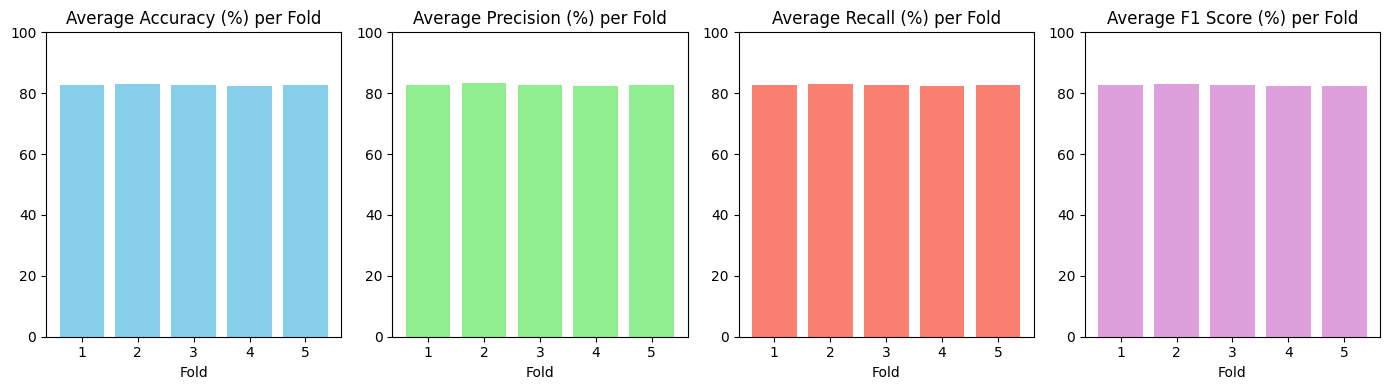


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     82.65       82.70       82.65       82.64       
2     83.16       83.20       83.16       83.15       
3     82.69       82.77       82.69       82.68       
4     82.34       82.45       82.34       82.33       
5     82.54       82.70       82.54       82.52       


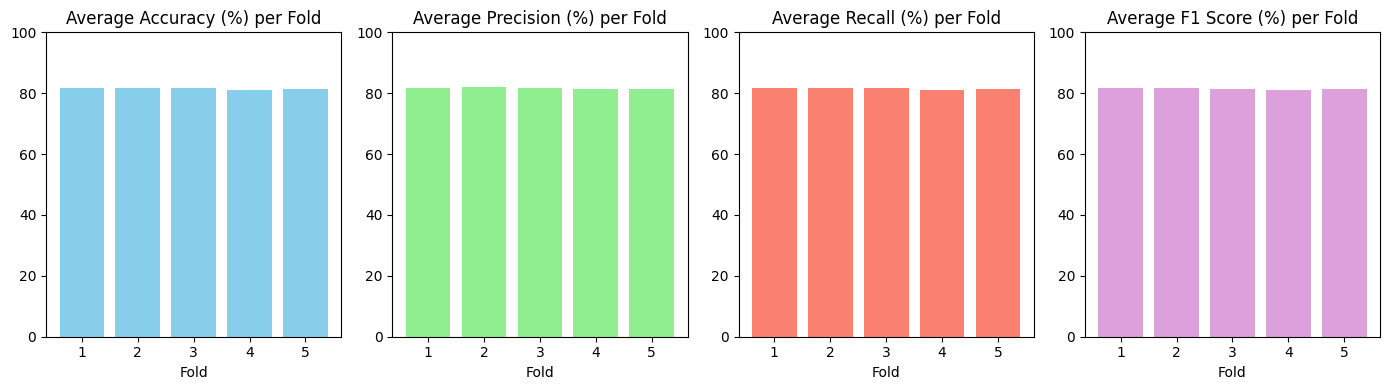


Average Metrics (%) Across Epochs Per Fold:
------------------------------------------------------------
Fold  Accuracy    Precision   Recall      F1 Score    
------------------------------------------------------------
1     81.63       81.69       81.63       81.62       
2     81.86       81.91       81.86       81.85       
3     81.55       81.67       81.55       81.53       
4     81.19       81.26       81.19       81.18       
5     81.26       81.45       81.26       81.23       


In [ ]:
# Plot cross-validation performance metrics (average of epochs) per fold
plot_avg_epoch_metrics_per_fold(best_fold_results_pretrained_model)
plot_avg_epoch_metrics_per_fold(best_fold_results_custom_model)

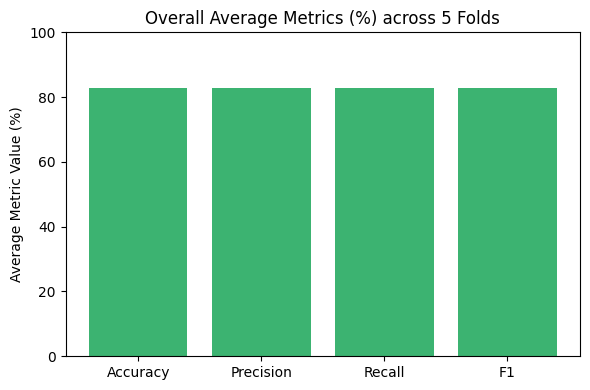


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         82.68
Precision        82.77
Recall           82.68
F1               82.66


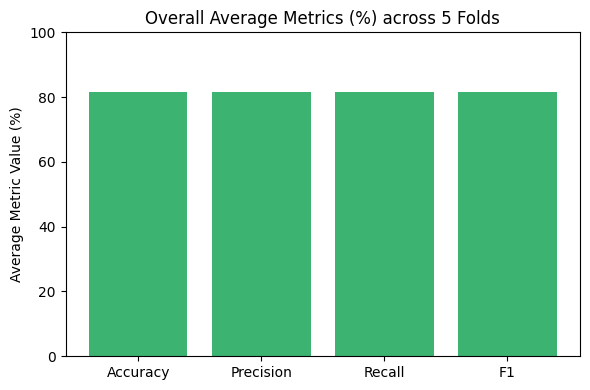


Overall Average Metrics Across Folds:
----------------------------------------
Metric       Value (%)
----------------------------------------
Accuracy         81.50
Precision        81.59
Recall           81.50
F1               81.48


In [ ]:
# Plot average performance metrics (average of epochs) for 5-fold
plot_avg_epoch_metrics_across_folds(best_fold_results_pretrained_model)
plot_avg_epoch_metrics_across_folds(best_fold_results_custom_model)

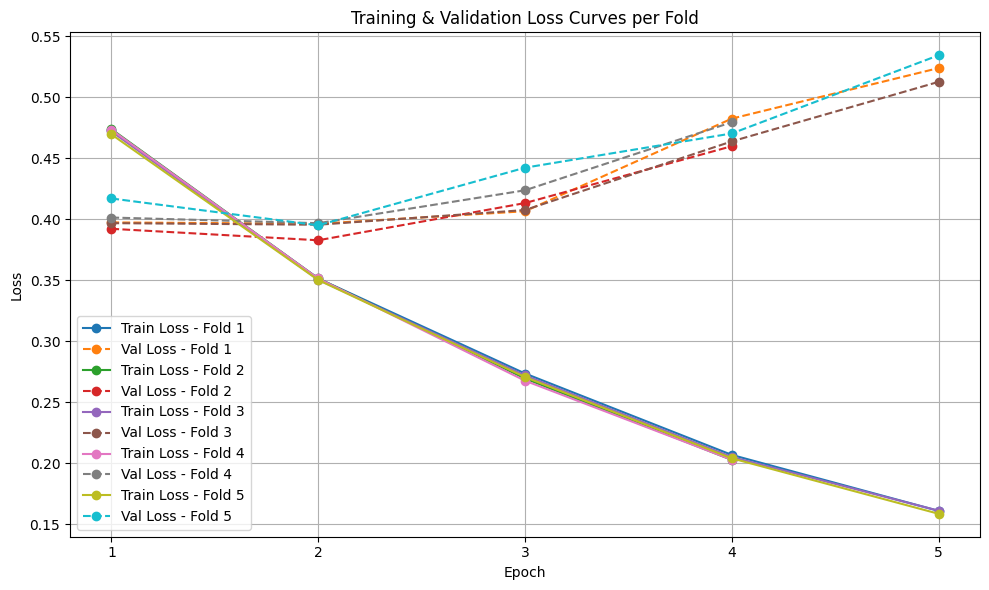


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4732         0.3974         
1     2       0.3514         0.3964         
1     3       0.2735         0.4066         
1     4       0.2067         0.4826         
1     5       0.1608         0.5241         
--------------------------------------------------
2     1       0.4740         0.3922         
2     2       0.3515         0.3828         
2     3       0.2694         0.4133         
2     4       0.2026         0.4600         
--------------------------------------------------
3     1       0.4721         0.3969         
3     2       0.3505         0.3956         
3     3       0.2719         0.4076         
3     4       0.2050         0.4639         
3     5       0.1609         0.5128         
--------------------------------------------------
4     1       0.4735         0.4015  

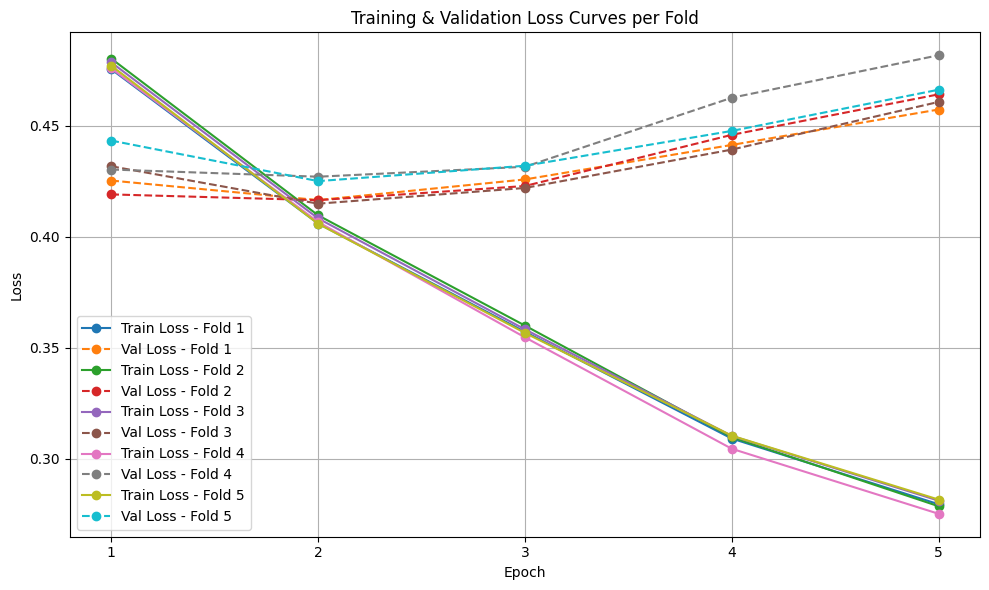


Loss Values per Fold and Epoch:
--------------------------------------------------
Fold  Epoch   Train Loss     Val Loss       
--------------------------------------------------
1     1       0.4754         0.4253         
1     2       0.4059         0.4165         
1     3       0.3571         0.4258         
1     4       0.3090         0.4413         
1     5       0.2794         0.4573         
--------------------------------------------------
2     1       0.4802         0.4190         
2     2       0.4096         0.4164         
2     3       0.3599         0.4228         
2     4       0.3096         0.4459         
2     5       0.2785         0.4641         
--------------------------------------------------
3     1       0.4785         0.4317         
3     2       0.4082         0.4148         
3     3       0.3582         0.4219         
3     4       0.3102         0.4392         
3     5       0.2810         0.4607         
-------------------------------------------

,Fold,Epoch,Train Loss,Validation Loss
0,1,1,0.4754,0.425261
1,1,2,0.4059,0.416472
2,1,3,0.3571,0.425761
3,1,4,0.3090,0.441312
4,1,5,0.2794,0.457274
5,2,1,0.4802,0.419017
6,2,2,0.4096,0.416421
7,2,3,0.3599,0.422803
8,2,4,0.3096,0.445855
9,2,5,0.2785,0.464108


In [ ]:
# Plot training and validation loss curves per fold
plot_loss_per_fold(best_fold_results_pretrained_model)
plot_loss_per_fold(best_fold_results_custom_model)

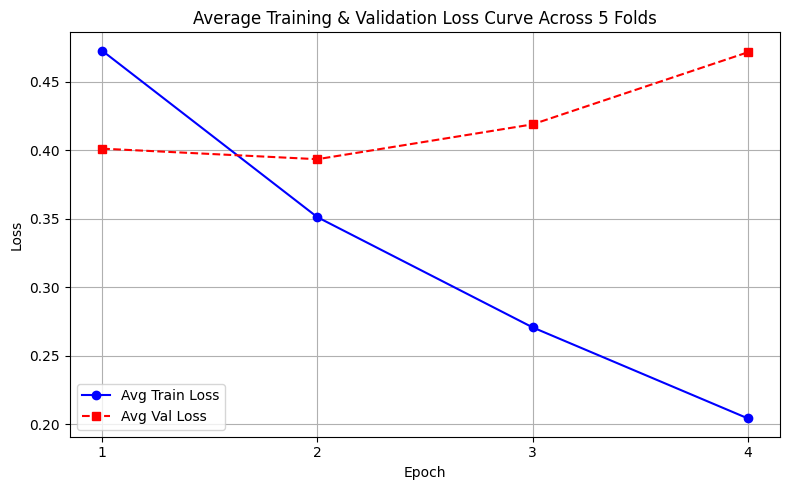


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4725          0.4010          
2       0.3510          0.3933          
3       0.2706          0.4187          
4       0.2042          0.4713          


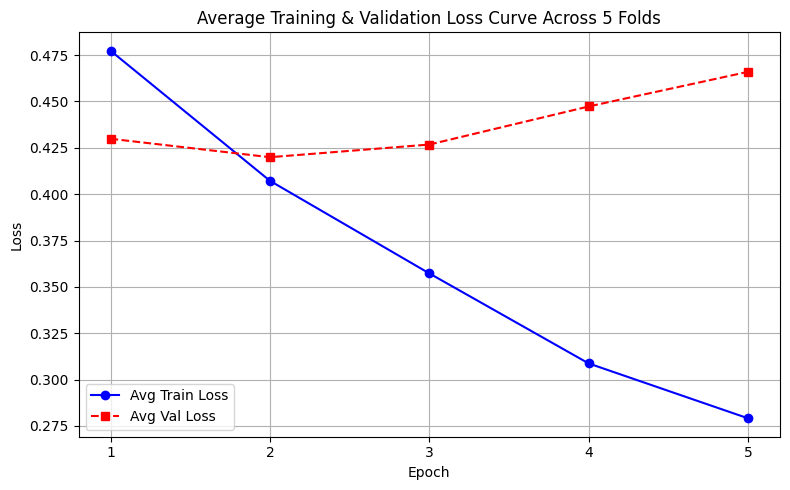


Average Loss per Epoch Across Folds:
---------------------------------------------
Epoch   Train Loss      Val Loss        
---------------------------------------------
1       0.4774          0.4299          
2       0.4072          0.4199          
3       0.3573          0.4268          
4       0.3087          0.4473          
5       0.2791          0.4660          


,Epoch,Avg Train Loss,Avg Validation Loss
0,1,0.47738,0.429896
1,2,0.40722,0.419946
2,3,0.35728,0.426776
3,4,0.30870,0.447315
4,5,0.27910,0.465997


In [ ]:
# Plot average training and validation loss curves for 5-fold
plot_avg_loss_across_folds(best_fold_results_pretrained_model)
plot_avg_loss_across_folds(best_fold_results_custom_model)

---
# **4.2 Final Model Training**

## Define Best Final Training Arguments

In [ ]:
def create_best_training_args(best_params, model_loader):
    # Create a new TrainingArguments object using best_params
    best_training_args = TrainingArguments(
        output_dir=f"./best_tuned_final_results_{model_loader.__name__}",
        do_train=True,
        report_to="none",                # Disable external logging
        eval_strategy="no",              # No evaluation during training
        save_strategy="no",              # Do not save at each epoch
        per_device_train_batch_size=best_params["batch_size"],
        per_device_eval_batch_size=best_params["batch_size"],
        num_train_epochs=5,
        learning_rate=best_params["learning_rate"],
        weight_decay=best_params["weight_decay"],
        fp16=True,                       # Enable mixed precision training
        gradient_accumulation_steps=best_params["grad_acc"],
        logging_dir=f"./best_tuned_final_logs_{model_loader.__name__}",
        logging_strategy="epoch",
        seed=42,
        # Additional parameters with defaults if not set in best_params
        warmup_steps=best_params.get("warmup_steps", 0),
        max_grad_norm=best_params.get("max_grad_norm", 1.0),
        adam_epsilon=best_params.get("adam_epsilon", 1e-8),
        lr_scheduler_type=best_params.get("scheduler", "linear"),
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1",
        greater_is_better=True
    )
    return best_training_args

In [ ]:
# Train the final model using pretrained DistilBert
model_loader = load_pretrained_model
training_args = create_best_training_args(best_params1, model_loader)
tuned_final_pretrained_trainer, tuned_final_pretrained_model = train_final_model(full_train_dataset, training_args, model_loader)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-31-e6ccdbd24bf5>:10: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Step,Training Loss
1239,0.459000
2478,0.343100
3717,0.267300
4956,0.202800
6190,0.158500


In [ ]:
# Train on the full training set (already tokenized)
best_model_loader = lambda: load_custom_model(
    hidden_units=[best_params2[k] for k in hidden_unit_keys],
    dropout_rate=best_params2["dropout_rate"],
    activation=activation_map[best_params2["activation"]]
)
training_args = create_best_training_args(best_params2, best_model_loader)
tuned_final_custom_trainer, tuned_final_custom_model = train_final_model(full_train_dataset, training_args, best_model_loader)

<ipython-input-31-e6ccdbd24bf5>:10: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Step,Training Loss
2478,0.471400
4956,0.404000
7434,0.357100
9912,0.309900
12385,0.283000


---
# **4.3 Final Model Evaluation**

In [ ]:
# Evaluate the final model using pretrained DistilBert
evaluate_final_model(tuned_final_pretrained_trainer, test_dataset)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8237 (82.37%)
Precision      0.8238 (82.38%)
Recall         0.8237 (82.37%)
F1 Score       0.8237 (82.37%)
Loss           0.5323
--------------------------------------------------


{'eval_loss': 0.5322930216789246,
 'eval_accuracy': 0.8237045259599375,
 'eval_precision': 0.8238303500876107,
 'eval_recall': 0.8237045259599375,
 'eval_f1': 0.8236933030174771,
 'eval_runtime': 12.5571,
 'eval_samples_per_second': 1578.315,
 'eval_steps_per_second': 98.67,
 'epoch': 4.996165489404642}

In [ ]:
# Evaluate the final model using custom DistilBert
evaluate_final_model(tuned_final_custom_trainer, test_dataset)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8172 (81.72%)
Precision      0.8175 (81.75%)
Recall         0.8172 (81.72%)
F1 Score       0.8172 (81.72%)
Loss           0.4597
--------------------------------------------------


{'eval_loss': 0.4596530795097351,
 'eval_accuracy': 0.8171956203642969,
 'eval_precision': 0.8174504930605009,
 'eval_recall': 0.8171956203642969,
 'eval_f1': 0.8171679194049352,
 'eval_runtime': 21.7888,
 'eval_samples_per_second': 909.595,
 'eval_steps_per_second': 113.728,
 'epoch': 4.998183652875883}

---
# **4.4 Final Model Prediction**

## Predict, Compute and Print Evaluation Metrics


Final Model Predictions Summary
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8237 (82.37%)
Precision      0.8238 (82.38%)
Recall         0.8237 (82.37%)
F1 Score       0.8237 (82.37%)
--------------------------------------------------

Classification Report (Per Class):
              precision    recall  f1-score   support

    Negative     0.8172    0.8327    0.8249      9882
    Positive     0.8304    0.8147    0.8225      9937

    accuracy                         0.8237     19819
   macro avg     0.8238    0.8237    0.8237     19819
weighted avg     0.8238    0.8237    0.8237     19819


Confusion Matrix:
[[8229 1653]
 [1841 8096]]

Confusion matrix saved to ./2_Fine_Tuned_Pretrained_Model_Cleaned_And_Removed_Dups_Tweets/confusion_matrix.png



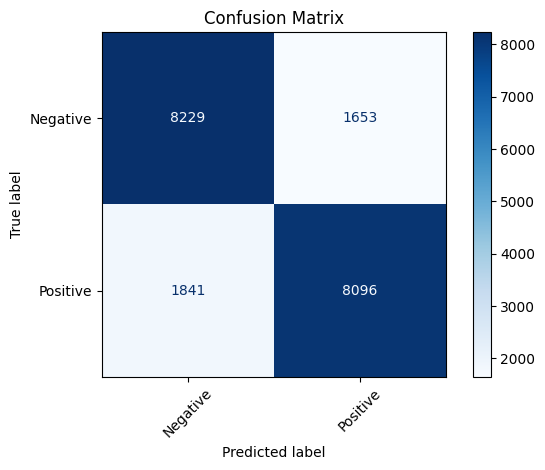

In [ ]:
model_name = "2_Fine_Tuned_Pretrained_Model_Cleaned_And_Removed_Dups_Tweets"

# Get predictions, metrics from confusion matrix and save visualization
prediction_metrics, cm, preds, labels = predict_final_model_with_metrics(
    tuned_final_pretrained_trainer,
    test_dataset,
    output_dir=f"./{model_name}",
    class_labels=["Negative", "Positive"]
)


Final Model Predictions Summary
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8172 (81.72%)
Precision      0.8175 (81.75%)
Recall         0.8172 (81.72%)
F1 Score       0.8172 (81.72%)
--------------------------------------------------

Classification Report (Per Class):
              precision    recall  f1-score   support

    Negative     0.8082    0.8305    0.8192      9882
    Positive     0.8267    0.8040    0.8152      9937

    accuracy                         0.8172     19819
   macro avg     0.8174    0.8172    0.8172     19819
weighted avg     0.8175    0.8172    0.8172     19819


Confusion Matrix:
[[8207 1675]
 [1948 7989]]

Confusion matrix saved to ./2_Fine_Tuned_Custom_Model_Cleaned_And_Removed_Dups_Tweets/confusion_matrix.png



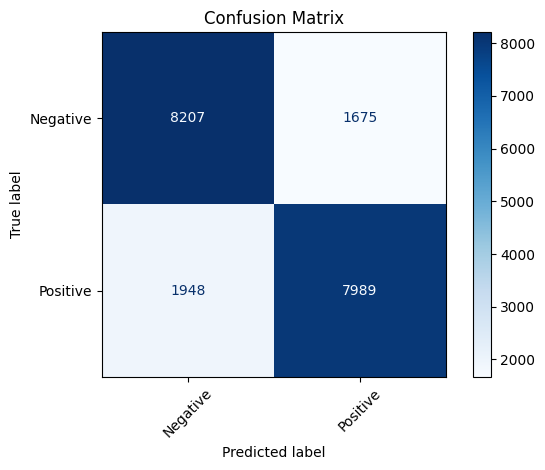

In [ ]:
model_name = "2_Fine_Tuned_Custom_Model_Cleaned_And_Removed_Dups_Tweets"

# Get predictions, metrics from confusion matrix and save visualization
prediction_metrics, cm, preds, labels = predict_final_model_with_metrics(
    tuned_final_custom_trainer,
    test_dataset,
    output_dir=f"./{model_name}",
    class_labels=["Negative", "Positive"]
)

---
# **4.5 Save Final Model**

In [ ]:
model_name = "2_Fine_Tuned_Pretrained_Model_Cleaned_And_Removed_Dups_Tweets"
final_model_eval_metrics = evaluate_final_model(tuned_final_pretrained_trainer, test_dataset)
metrics3 = {
    "trainer_evaluation": final_model_eval_metrics,
    "confusion_matrix_metrics": prediction_metrics
}
save_model_to_drive(tuned_final_pretrained_model, tokenizer, model_name, metrics=metrics3)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8237 (82.37%)
Precision      0.8238 (82.38%)
Recall         0.8237 (82.37%)
F1 Score       0.8237 (82.37%)
Loss           0.5323
--------------------------------------------------
Mounted at /content/drive
Model and metrics saved to Google Drive at: /content/drive/My Drive/Colab Notebooks/IT1244 Project/Saved Model/2_Fine_Tuned_Pretrained_Model_Cleaned_And_Removed_Dups_Tweets


In [ ]:
model_name = "2_Fine_Tuned_Custom_Model_Cleaned_And_Removed_Dups_Tweets"
final_model_eval_metrics = evaluate_final_model(tuned_final_custom_trainer, test_dataset)
metrics4 = {
    "trainer_evaluation": final_model_eval_metrics,
    "confusion_matrix_metrics": prediction_metrics
}
save_model_to_drive(tuned_final_custom_model, tokenizer, model_name, metrics=metrics4)


Final Model Evaluation on the Test Set:
--------------------------------------------------
Metric              Value
--------------------------------------------------
Accuracy       0.8172 (81.72%)
Precision      0.8175 (81.75%)
Recall         0.8172 (81.72%)
F1 Score       0.8172 (81.72%)
Loss           0.4597
--------------------------------------------------
Mounted at /content/drive
Model and metrics saved to Google Drive at: /content/drive/My Drive/Colab Notebooks/IT1244 Project/Saved Model/2_Fine_Tuned_Custom_Model_Cleaned_And_Removed_Dups_Tweets
